# Train using balanced subsets of data - 224x224 Redux

### Findings
- Dataset has propensity for flucting validation loss, even with increated dropotuand reduced model layers
- Training at very low LR (1e4) gives more stable results, bult ultimately sub-optimal final results
- Better results achieved using higher LR, and using SaveModelCallback to capture local minima
- Combining multiple top learners gives significantly better results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import collections

In [3]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os
import pickle

import scipy
from scipy.stats import gmean, hmean

In [4]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, \
                          get_accuracy, analyze_confidence, accuracy_vs_threshold, \
                          show_incremental_accuracy,  analyze_low_confidence, \
                          plot_confusion_matrix_thresh, get_val_stats, model_cutter

In [5]:
#from pneumonia_loaders import *

In [6]:
from pneumonia_loaders import show_categories
from pneumonia_new_loader import get_db

In [7]:
from helpers import get_best_stats, show_results, show_results
from helpers import StatsRepo, stats_repo_unit_test
from helpers import _get_learner, _get_interp, analyze_interp, _do_train

# Config

In [8]:
model = models.resnet18
size=224
n_samples=200    # total number of training samples

In [9]:
#data_base = Path()/'data'
data_base = Path.home()/'big_ssd'/'Data'/'ChestXRay_Kaggle'




#model_base = Path('D:/Users/Doug/Models/chest_xray')
model_base = Path.home()/'D_Drive'/'Models'/'chest_xray'

all_bs = {224:31, 448:31, 896:7}

In [10]:
prefix = f'f18_{size}'
short_prefix = f'f18_{size}'

data_subdir  = f'chest_xray_{size}'
model_subdir = f'f18_{size}'

if size in [224]:
    path = data_base/data_subdir
    model_dir = (model_base/model_subdir).absolute()
    bs = all_bs[size]
else:
    raise Exception('Unknown size')

In [11]:
bs, model_dir

(31, PosixPath('/home/doug/D_Drive/Models/chest_xray/f18_224'))

In [12]:
path.ls()

[PosixPath('/home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224/models'),
 PosixPath('/home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224/val'),
 PosixPath('/home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224/train'),
 PosixPath('/home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224/test')]

# Code

In [13]:
def my_transforms():
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    return tfms

In [14]:
def get_params(all_lr=[1e-2, 3e-3, 1e-3], all_cycles=[1,2,4, 8]):
    global short_prefix
    for lr in all_lr:
        for cycles in all_cycles:
            key = f'{short_prefix}_lr_{lr}_cyc_{cycles}'
            yield key, {'cycles':cycles, 'max_lr':lr}

In [15]:
def restore_learner(name, ps=0.5, compute_baseline=True):
    learn = get_learner(ps=ps)
    learn.load(name)
    
    if compute_baseline:
        base = learn.svalidate()
        base = {'loss': base[0], 'error_rate': float(base[1]), 'accuracy': float(base[2])}
    else:
        base = None
    return learn, base

def refine_learner(name, ps=0.8, lr=1e-6, cycles=16, **kwargs):
    learn, base = restore_learner(name, ps=ps)
    print('base:', base)
    learn.unfreeze()
    learn.fit_one_cycle(cycles, max_lr=slice(lr,lr),
                        callbacks=[SaveModelCallback(learn, every='improvement', 
                                   monitor='accuracy', name='best')], **kwargs)
    stats = get_best_stats(learn)
    
    if stats['error_rate'] < base['error_rate']:
        new_name = f'{name}_r_lr{lr}_c{cycles}_ps{ps}'
        print('keeping:', stats)
        return learn, stats, new_name
    else:
        print('ignoring:', stats)
        return None, None, None

# Additional Configuration

###### Initialize stats repo (use prior contents if available)

In [16]:
all_stats = StatsRepo(prefix, force_init=False, verbose=True)

initialializing stats


###### Get Training/Validation/Test dataset for  Normal / Viral / Bacterial

In [17]:
#data = get_db_np(path, size=size, scale=10, tfms=my_transforms())
data, data_test = get_db(path, kind='np', n_samples=n_samples, scale=1, include_test=True,
                  size=size, bs=bs, tfms=my_transforms())
print('Training set:')
show_categories(data.train_ds.y)
print('\nValidation set:')
show_categories(data.valid_ds.y)
print('\nTest set:')
show_categories(data_test.valid_ds.y)

Training set:
  NORMAL    :   200     50.0%
  PNEUMONIA :   200     50.0%
  Total     :   400

Validation set:
  NORMAL    :   117     50.0%
  PNEUMONIA :   117     50.0%
  Total     :   234

Test set:
  NORMAL    :   117     50.0%
  PNEUMONIA :   117     50.0%
  Total     :   234


In [18]:
data

ImageDataBunch;

Train: LabelList (400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,NORMAL,NORMAL,NORMAL,PNEUMONIA
Path: /home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224;

Valid: LabelList (234 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,NORMAL,NORMAL,NORMAL,PNEUMONIA
Path: /home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224;

Test: None

###### Define configuration specific functions and initialize stats repo (use prior contents if available)

In [19]:
get_learner = partial(_get_learner, db=data, model=model, model_dir=model_dir)
get_learner_test = partial(_get_learner, db=data_test, model=model, model_dir=model_dir)

get_interp = partial(_get_interp, get_learner=get_learner)
get_interp_test = partial(_get_interp, get_learner=get_learner_test)

do_train = partial(_do_train, get_learner=get_learner, stats_repo=all_stats)
do_train_ls = partial(_do_train, get_learner=get_learner, stats_repo=all_stats,
                      use_label_smoothing=True)

In [20]:
import scipy
from scipy.stats import gmean, hmean

def compute_acc(preds, y_true):
    yy = np.argmax(preds, axis=-1)
    return np.mean(yy==y_true)
    

def combine_predictions(all_interp):
    y_true = to_np(all_interp[0][1].y_true)
    all_preds = np.stack([to_np(interp.preds) for _, interp in all_interp])
    
    preds = np.mean(all_preds, axis=0)
    acc_m = compute_acc(preds, y_true) 
    
    preds = np.median(all_preds, axis=0)
    acc_med = compute_acc(preds, y_true)
    
    preds = gmean(all_preds, axis=0)
    acc_g = compute_acc(preds, y_true)
    
    preds = hmean(all_preds, axis=0)
    acc_h = compute_acc(preds, y_true)
    
    print(f'accuracy -- mean: {acc_m:0.3f}   median: {acc_med:0.3f}   gmean: {acc_g:0.3f}   hmean: {acc_h:0.3f}')
    return acc_m, acc_med, acc_g, acc_h

## Various Development Tests
Disabled by default

# Analysis

In [21]:
# barrier after initialization for notebook restart
#assert False

### Basic LR Finder runs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04 
Min loss divided by 10: 1.58E-03
Min numerical gradient: 4.79E-04  (smoothed)
Min numerical gradient: 2.09E-03
Min loss divided by 10: 2.75E-03


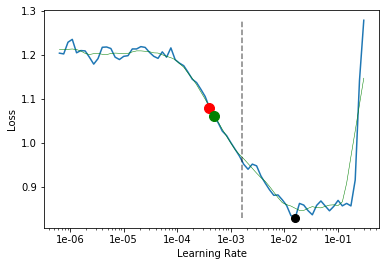

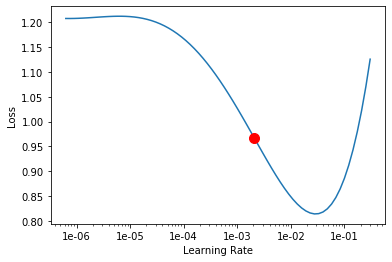

In [22]:
learn = get_learner()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

## Explore Baseline

f18_224_lr_0.01_cyc_1


Better model found at epoch 0 with accuracy value: 0.8547008633613586.


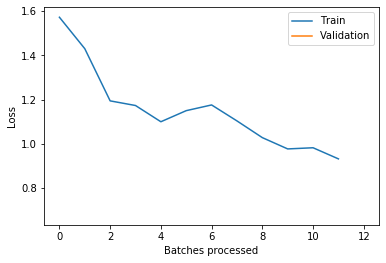

f18_224_lr_0.01_cyc_2


Better model found at epoch 0 with accuracy value: 0.5940170884132385.


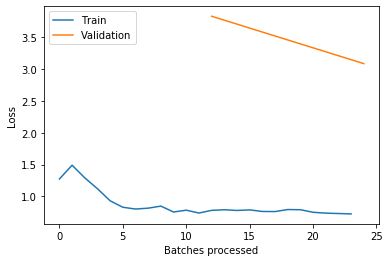

f18_224_lr_0.01_cyc_4


Better model found at epoch 0 with accuracy value: 0.5811966061592102.
Better model found at epoch 2 with accuracy value: 0.688034176826477.
Better model found at epoch 3 with accuracy value: 0.8632478713989258.


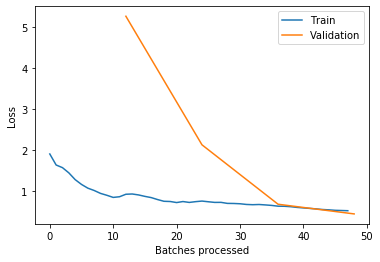

f18_224_lr_0.01_cyc_8


Better model found at epoch 0 with accuracy value: 0.688034176826477.
Better model found at epoch 1 with accuracy value: 0.7649572491645813.
Better model found at epoch 4 with accuracy value: 0.7863247990608215.
Better model found at epoch 6 with accuracy value: 0.811965823173523.
Better model found at epoch 7 with accuracy value: 0.8418803215026855.


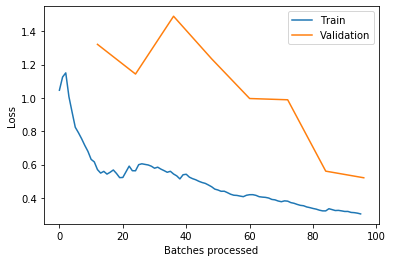

f18_224_lr_0.003_cyc_1


Better model found at epoch 0 with accuracy value: 0.6495726704597473.


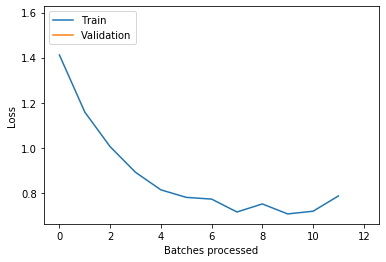

f18_224_lr_0.003_cyc_2


Better model found at epoch 0 with accuracy value: 0.7863247990608215.


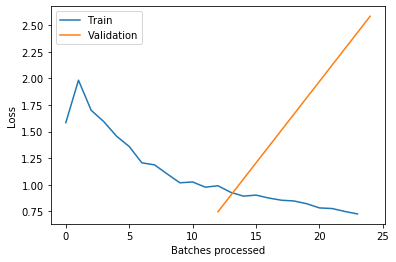

f18_224_lr_0.003_cyc_4


Better model found at epoch 0 with accuracy value: 0.7094017267227173.


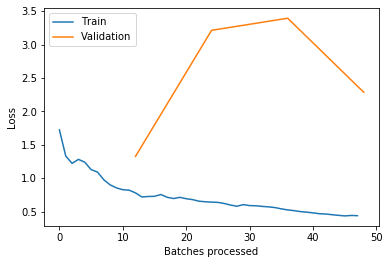

f18_224_lr_0.003_cyc_8


Better model found at epoch 0 with accuracy value: 0.8247863054275513.
Better model found at epoch 4 with accuracy value: 0.8418803215026855.
Better model found at epoch 6 with accuracy value: 0.8589743375778198.


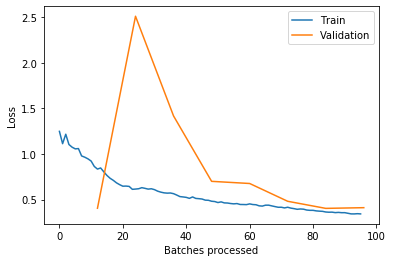

f18_224_lr_0.001_cyc_1


Better model found at epoch 0 with accuracy value: 0.8418803215026855.


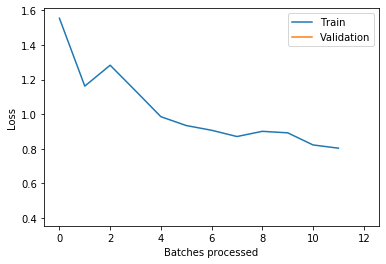

f18_224_lr_0.001_cyc_2


Better model found at epoch 0 with accuracy value: 0.811965823173523.


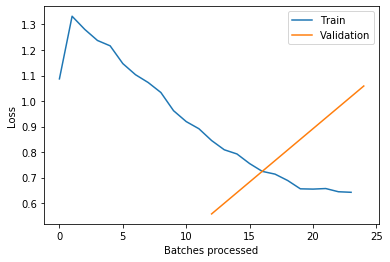

f18_224_lr_0.001_cyc_4


Better model found at epoch 0 with accuracy value: 0.8461538553237915.


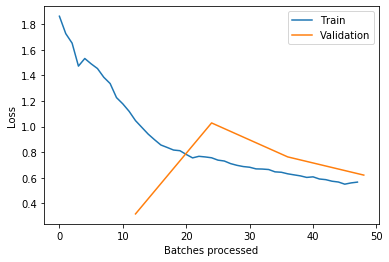

f18_224_lr_0.001_cyc_8


Better model found at epoch 0 with accuracy value: 0.6111111044883728.
Better model found at epoch 1 with accuracy value: 0.688034176826477.
Better model found at epoch 2 with accuracy value: 0.7350427508354187.
Better model found at epoch 3 with accuracy value: 0.7649572491645813.
Better model found at epoch 4 with accuracy value: 0.7735042572021484.
Better model found at epoch 5 with accuracy value: 0.8290598392486572.
Better model found at epoch 6 with accuracy value: 0.867521345615387.
Better model found at epoch 7 with accuracy value: 0.8717948794364929.


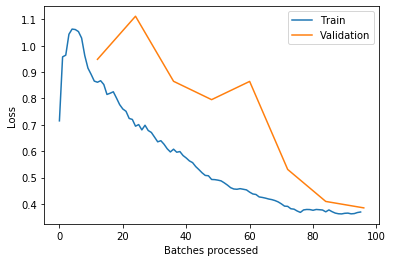

saved stats to: stats/f18_224_stats.p


In [23]:
for key, params in get_params():
    do_train(key, **params)
all_stats.save()

f18_224_lr_0.0003_cyc_1


Better model found at epoch 0 with accuracy value: 0.692307710647583.


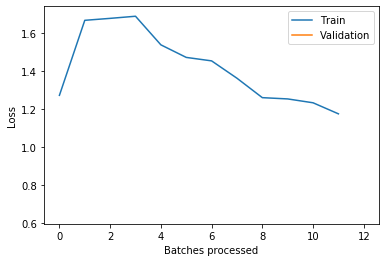

f18_224_lr_0.0003_cyc_2


Better model found at epoch 0 with accuracy value: 0.504273533821106.


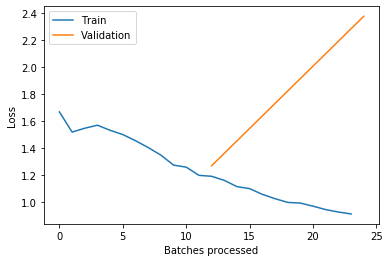

f18_224_lr_0.0003_cyc_4


Better model found at epoch 0 with accuracy value: 0.8290598392486572.


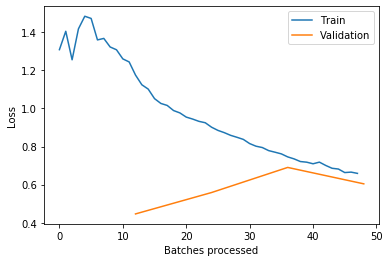

f18_224_lr_0.0003_cyc_8


Better model found at epoch 0 with accuracy value: 0.5085470080375671.
Better model found at epoch 1 with accuracy value: 0.5555555820465088.
Better model found at epoch 2 with accuracy value: 0.6452991366386414.
Better model found at epoch 3 with accuracy value: 0.7393162250518799.
Better model found at epoch 4 with accuracy value: 0.811965823173523.
Better model found at epoch 5 with accuracy value: 0.8589743375778198.
Better model found at epoch 6 with accuracy value: 0.8760683536529541.
Better model found at epoch 7 with accuracy value: 0.8846153616905212.


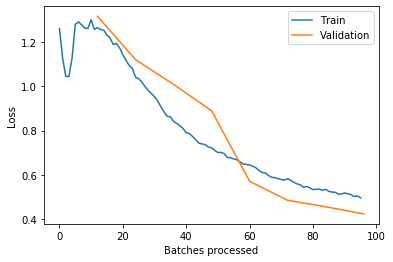

f18_224_lr_0.0001_cyc_1


Better model found at epoch 0 with accuracy value: 0.49145299196243286.


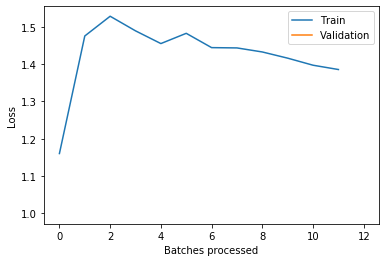

f18_224_lr_0.0001_cyc_2


Better model found at epoch 0 with accuracy value: 0.6495726704597473.
Better model found at epoch 1 with accuracy value: 0.7136752009391785.


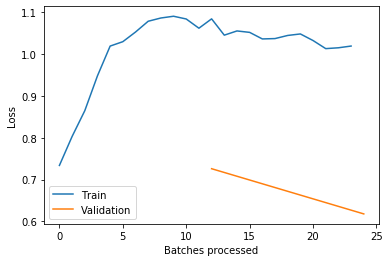

f18_224_lr_0.0001_cyc_4


Better model found at epoch 0 with accuracy value: 0.6538461446762085.
Better model found at epoch 1 with accuracy value: 0.7606837749481201.
Better model found at epoch 3 with accuracy value: 0.7905982732772827.


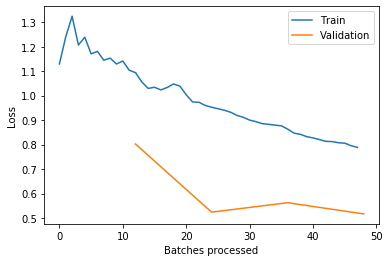

f18_224_lr_0.0001_cyc_8


Better model found at epoch 0 with accuracy value: 0.44017094373703003.
Better model found at epoch 1 with accuracy value: 0.4572649598121643.
Better model found at epoch 2 with accuracy value: 0.5982906222343445.
Better model found at epoch 3 with accuracy value: 0.7350427508354187.
Better model found at epoch 4 with accuracy value: 0.7948718070983887.
Better model found at epoch 5 with accuracy value: 0.8333333134651184.


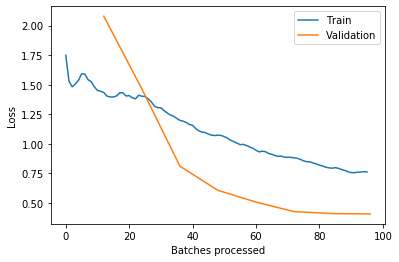

saved stats to: stats/f18_224_stats.p


In [24]:
for key, params in get_params(all_lr=[3e-4, 1e-4]):
    do_train(key, **params)
all_stats.save()

In [25]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.115  med: 0.179   Loss -- best: 0.317  med: 0.539

f18_224_lr_0.0003_cyc_8  error_rate: 0.115   accuracy: 0.885   loss:0.4228
f18_224_lr_0.001_cyc_8  error_rate: 0.128   accuracy: 0.872   loss:0.3851
f18_224_lr_0.01_cyc_4  error_rate: 0.137   accuracy: 0.863   loss:0.4360
f18_224_lr_0.003_cyc_8  error_rate: 0.141   accuracy: 0.859   loss:0.4038
f18_224_lr_0.01_cyc_1  error_rate: 0.145   accuracy: 0.855   loss:0.6802
f18_224_lr_0.001_cyc_4  error_rate: 0.154   accuracy: 0.846   loss:0.3175
f18_224_lr_0.01_cyc_8  error_rate: 0.158   accuracy: 0.842   loss:0.5208
f18_224_lr_0.001_cyc_1  error_rate: 0.158   accuracy: 0.842   loss:0.4115
f18_224_lr_0.0001_cyc_8  error_rate: 0.167   accuracy: 0.833   loss:0.4280
f18_224_lr_0.0003_cyc_4  error_rate: 0.171   accuracy: 0.829   loss:0.4460


f18_224_lr_0.03_cyc_1


Better model found at epoch 0 with accuracy value: 0.6495726704597473.


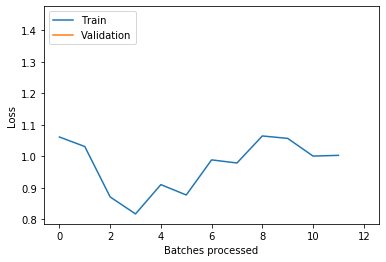

f18_224_lr_0.03_cyc_2


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.6025640964508057.


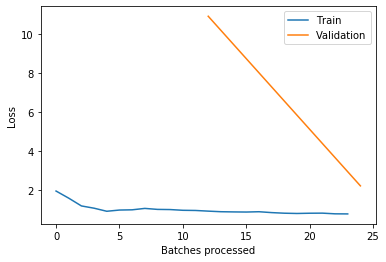

f18_224_lr_0.03_cyc_4


Better model found at epoch 0 with accuracy value: 0.7094017267227173.
Better model found at epoch 1 with accuracy value: 0.7393162250518799.
Better model found at epoch 3 with accuracy value: 0.7649572491645813.


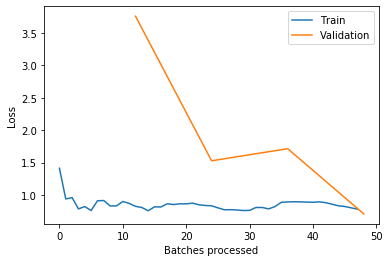

f18_224_lr_0.03_cyc_8


Better model found at epoch 0 with accuracy value: 0.7051281929016113.
Better model found at epoch 2 with accuracy value: 0.7606837749481201.
Better model found at epoch 4 with accuracy value: 0.8504273295402527.
Better model found at epoch 5 with accuracy value: 0.8888888955116272.
Better model found at epoch 6 with accuracy value: 0.9059829115867615.
Better model found at epoch 7 with accuracy value: 0.9188033938407898.


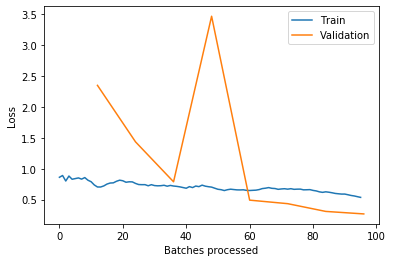

f18_224_lr_0.1_cyc_1


Better model found at epoch 0 with accuracy value: 0.4999999701976776.


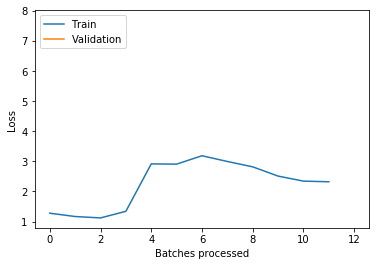

f18_224_lr_0.1_cyc_2


Better model found at epoch 0 with accuracy value: 0.5.


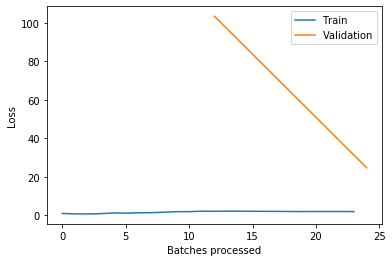

f18_224_lr_0.1_cyc_4


Better model found at epoch 0 with accuracy value: 0.4615384638309479.
Better model found at epoch 1 with accuracy value: 0.6239316463470459.
Better model found at epoch 2 with accuracy value: 0.6666666865348816.
Better model found at epoch 3 with accuracy value: 0.7008547186851501.


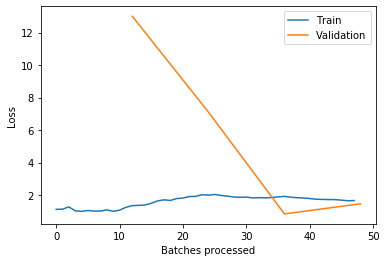

f18_224_lr_0.1_cyc_8


Better model found at epoch 0 with accuracy value: 0.5897436141967773.
Better model found at epoch 3 with accuracy value: 0.8504273295402527.
Better model found at epoch 6 with accuracy value: 0.8547008633613586.
Better model found at epoch 7 with accuracy value: 0.867521345615387.


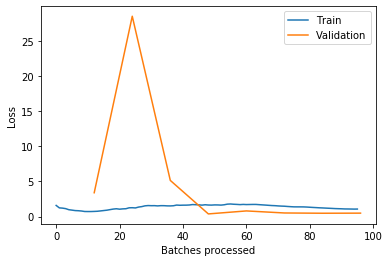

saved stats to: stats/f18_224_stats.p


In [26]:
for key, params in get_params(all_lr=[3e-2, 1e-1]):
    do_train(key, **params)
all_stats.save()

In [27]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.081  med: 0.212   Loss -- best: 0.267  med: 0.633

f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.0003_cyc_8  error_rate: 0.115   accuracy: 0.885   loss:0.4228
f18_224_lr_0.001_cyc_8  error_rate: 0.128   accuracy: 0.872   loss:0.3851
f18_224_lr_0.1_cyc_8  error_rate: 0.132   accuracy: 0.868   loss:0.4914
f18_224_lr_0.01_cyc_4  error_rate: 0.137   accuracy: 0.863   loss:0.4360
f18_224_lr_0.003_cyc_8  error_rate: 0.141   accuracy: 0.859   loss:0.4038
f18_224_lr_0.01_cyc_1  error_rate: 0.145   accuracy: 0.855   loss:0.6802
f18_224_lr_0.001_cyc_4  error_rate: 0.154   accuracy: 0.846   loss:0.3175
f18_224_lr_0.01_cyc_8  error_rate: 0.158   accuracy: 0.842   loss:0.5208
f18_224_lr_0.001_cyc_1  error_rate: 0.158   accuracy: 0.842   loss:0.4115


f18_224_lr_0.001_cyc_16_ps_0.5


Better model found at epoch 0 with accuracy value: 0.6623931527137756.
Better model found at epoch 1 with accuracy value: 0.8290598392486572.
Better model found at epoch 5 with accuracy value: 0.8418803215026855.
Better model found at epoch 6 with accuracy value: 0.8803418874740601.


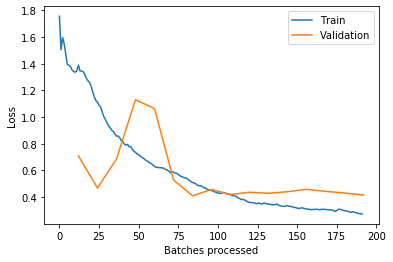

f18_224_lr_0.001_cyc_16_ps_0.8


Better model found at epoch 0 with accuracy value: 0.5726495981216431.
Better model found at epoch 2 with accuracy value: 0.6538461446762085.
Better model found at epoch 3 with accuracy value: 0.6965811848640442.
Better model found at epoch 4 with accuracy value: 0.7435897588729858.
Better model found at epoch 5 with accuracy value: 0.7991452813148499.
Better model found at epoch 6 with accuracy value: 0.8333333134651184.
Better model found at epoch 7 with accuracy value: 0.8504273295402527.
Better model found at epoch 8 with accuracy value: 0.867521345615387.


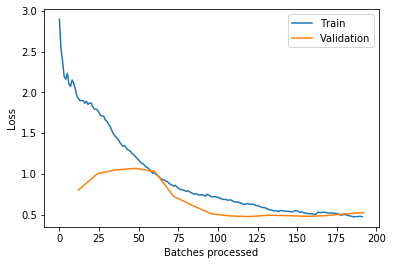

f18_224_lr_0.001_cyc_16_ps_0.85


Better model found at epoch 0 with accuracy value: 0.5256410241127014.
Better model found at epoch 1 with accuracy value: 0.6410256624221802.
Better model found at epoch 2 with accuracy value: 0.7307692170143127.
Better model found at epoch 5 with accuracy value: 0.8290598392486572.
Better model found at epoch 6 with accuracy value: 0.8888888955116272.
Better model found at epoch 7 with accuracy value: 0.9059829115867615.


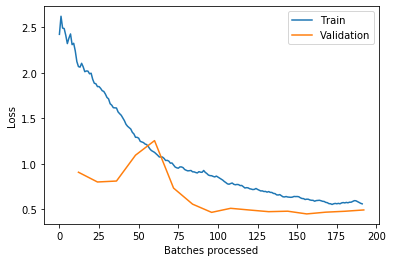

f18_224_lr_0.001_cyc_16_ps_0.9


Better model found at epoch 0 with accuracy value: 0.6196581125259399.
Better model found at epoch 1 with accuracy value: 0.6666666865348816.
Better model found at epoch 2 with accuracy value: 0.6794871687889099.
Better model found at epoch 4 with accuracy value: 0.7863247990608215.
Better model found at epoch 5 with accuracy value: 0.8290598392486572.
Better model found at epoch 8 with accuracy value: 0.8333333134651184.
Better model found at epoch 9 with accuracy value: 0.8376068472862244.
Better model found at epoch 11 with accuracy value: 0.8504273295402527.


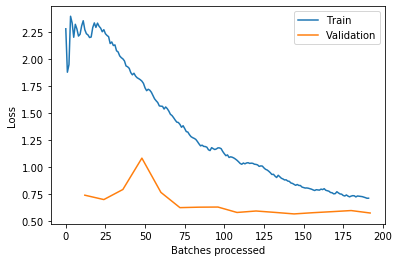

f18_224_lr_0.0003_cyc_16_ps_0.5


Better model found at epoch 0 with accuracy value: 0.5427350401878357.
Better model found at epoch 1 with accuracy value: 0.55982905626297.
Better model found at epoch 2 with accuracy value: 0.6282051205635071.
Better model found at epoch 3 with accuracy value: 0.6752136945724487.
Better model found at epoch 4 with accuracy value: 0.7435897588729858.
Better model found at epoch 5 with accuracy value: 0.7948718070983887.
Better model found at epoch 6 with accuracy value: 0.8461538553237915.
Better model found at epoch 7 with accuracy value: 0.8589743375778198.


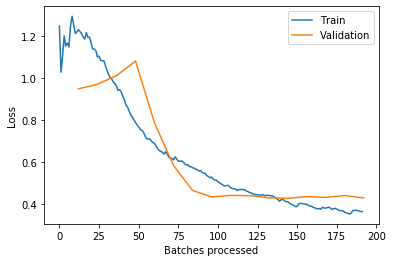

f18_224_lr_0.0003_cyc_16_ps_0.8


Better model found at epoch 0 with accuracy value: 0.41025641560554504.
Better model found at epoch 1 with accuracy value: 0.4572649598121643.
Better model found at epoch 2 with accuracy value: 0.5940170884132385.
Better model found at epoch 3 with accuracy value: 0.7264957427978516.
Better model found at epoch 4 with accuracy value: 0.8376068472862244.
Better model found at epoch 5 with accuracy value: 0.8418803215026855.
Better model found at epoch 6 with accuracy value: 0.867521345615387.
Better model found at epoch 12 with accuracy value: 0.8760683536529541.


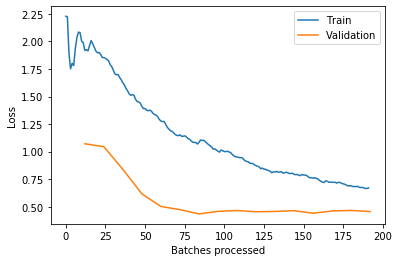

f18_224_lr_0.0003_cyc_16_ps_0.85


Better model found at epoch 0 with accuracy value: 0.5555555820465088.
Better model found at epoch 1 with accuracy value: 0.6282051205635071.
Better model found at epoch 3 with accuracy value: 0.6452991366386414.
Better model found at epoch 4 with accuracy value: 0.7435897588729858.
Better model found at epoch 5 with accuracy value: 0.7948718070983887.
Better model found at epoch 6 with accuracy value: 0.8418803215026855.
Better model found at epoch 7 with accuracy value: 0.8504273295402527.
Better model found at epoch 8 with accuracy value: 0.8547008633613586.
Better model found at epoch 11 with accuracy value: 0.867521345615387.


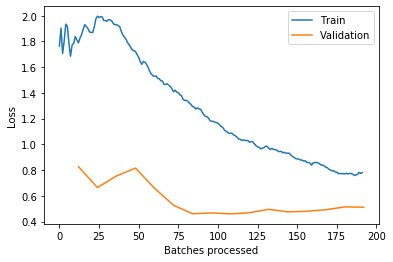

f18_224_lr_0.0003_cyc_16_ps_0.9


Better model found at epoch 0 with accuracy value: 0.3632478713989258.
Better model found at epoch 1 with accuracy value: 0.42307692766189575.
Better model found at epoch 2 with accuracy value: 0.47863247990608215.
Better model found at epoch 3 with accuracy value: 0.6666666865348816.
Better model found at epoch 4 with accuracy value: 0.7735042572021484.
Better model found at epoch 5 with accuracy value: 0.8205128312110901.
Better model found at epoch 6 with accuracy value: 0.8418803215026855.
Better model found at epoch 7 with accuracy value: 0.867521345615387.
Better model found at epoch 11 with accuracy value: 0.8760683536529541.


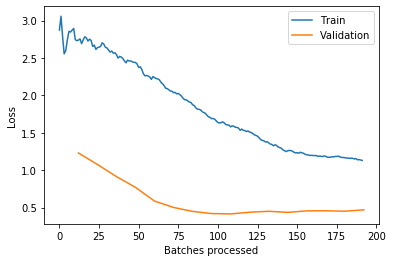

f18_224_lr_0.0001_cyc_16_ps_0.5


Better model found at epoch 0 with accuracy value: 0.49572649598121643.
Better model found at epoch 1 with accuracy value: 0.5982906222343445.
Better model found at epoch 2 with accuracy value: 0.7136752009391785.
Better model found at epoch 3 with accuracy value: 0.7735042572021484.
Better model found at epoch 4 with accuracy value: 0.8162392973899841.
Better model found at epoch 9 with accuracy value: 0.8247863054275513.
Better model found at epoch 12 with accuracy value: 0.8290598392486572.


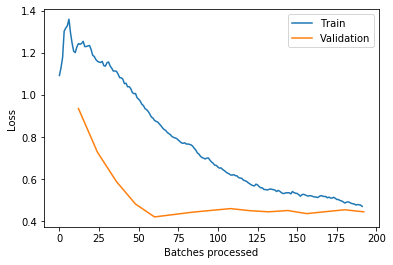

f18_224_lr_0.0001_cyc_16_ps_0.8


Better model found at epoch 0 with accuracy value: 0.4572649598121643.
Better model found at epoch 1 with accuracy value: 0.4829059839248657.
Better model found at epoch 2 with accuracy value: 0.5170940160751343.
Better model found at epoch 3 with accuracy value: 0.5769230723381042.
Better model found at epoch 4 with accuracy value: 0.6538461446762085.
Better model found at epoch 5 with accuracy value: 0.7179487347602844.
Better model found at epoch 6 with accuracy value: 0.7820512652397156.
Better model found at epoch 7 with accuracy value: 0.8632478713989258.
Better model found at epoch 11 with accuracy value: 0.867521345615387.
Better model found at epoch 12 with accuracy value: 0.8803418874740601.


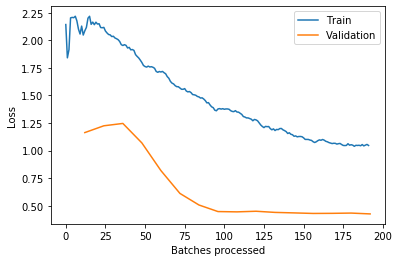

f18_224_lr_0.0001_cyc_16_ps_0.85


Better model found at epoch 0 with accuracy value: 0.6111111044883728.
Better model found at epoch 2 with accuracy value: 0.6239316463470459.
Better model found at epoch 3 with accuracy value: 0.6538461446762085.
Better model found at epoch 4 with accuracy value: 0.6794871687889099.
Better model found at epoch 5 with accuracy value: 0.747863233089447.
Better model found at epoch 6 with accuracy value: 0.8162392973899841.
Better model found at epoch 7 with accuracy value: 0.8461538553237915.
Better model found at epoch 9 with accuracy value: 0.8547008633613586.


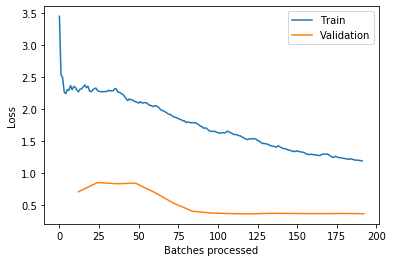

f18_224_lr_0.0001_cyc_16_ps_0.9


Better model found at epoch 0 with accuracy value: 0.41025641560554504.
Better model found at epoch 1 with accuracy value: 0.4615384638309479.
Better model found at epoch 3 with accuracy value: 0.5384615659713745.
Better model found at epoch 4 with accuracy value: 0.6367521286010742.
Better model found at epoch 5 with accuracy value: 0.7393162250518799.
Better model found at epoch 6 with accuracy value: 0.7948718070983887.
Better model found at epoch 7 with accuracy value: 0.811965823173523.
Better model found at epoch 8 with accuracy value: 0.8247863054275513.
Better model found at epoch 13 with accuracy value: 0.8290598392486572.


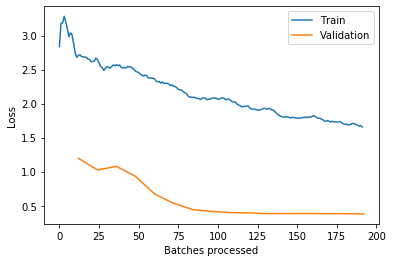

saved stats to: stats/f18_224_stats.p


In [28]:
for key, params in get_params(all_cycles=[16], all_lr=[1e-3, 3e-4, 1e-4]):
    for ps in [0.5, 0.8, 0.85, 0.9]:
        do_train(key, ps=ps, **params)
all_stats.save()

In [29]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.081  med: 0.162   Loss -- best: 0.267  med: 0.488

f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.0003_cyc_8  error_rate: 0.115   accuracy: 0.885   loss:0.4228
f18_224_lr_0.001_cyc_16_ps_0.5  error_rate: 0.120   accuracy: 0.880   loss:0.4101
f18_224_lr_0.0001_cyc_16_ps_0.8  error_rate: 0.120   accuracy: 0.880   loss:0.4313
f18_224_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.124   accuracy: 0.876   loss:0.4406
f18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.124   accuracy: 0.876   loss:0.4362
f18_224_lr_0.001_cyc_8  error_rate: 0.128   accuracy: 0.872   loss:0.3851
f18_224_lr_0.1_cyc_8  error_rate: 0.132   accuracy: 0.868   loss:0.4914
f18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.132   accuracy: 0.868   loss:0.4843


### Focus on specific configurations

18_224cut_lr_0.01_cyc_8

f18_224_lr_0.01_cyc_8_i0


Better model found at epoch 0 with accuracy value: 0.5170940160751343.
Better model found at epoch 1 with accuracy value: 0.6752136945724487.
Better model found at epoch 4 with accuracy value: 0.8034188151359558.
Better model found at epoch 5 with accuracy value: 0.8589743375778198.
Better model found at epoch 6 with accuracy value: 0.867521345615387.


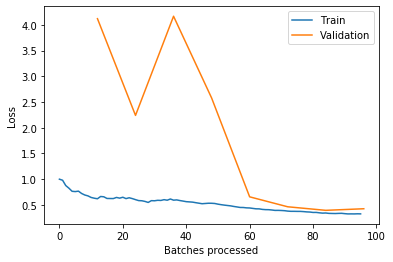

f18_224_lr_0.01_cyc_8_i1


Better model found at epoch 0 with accuracy value: 0.7008547186851501.
Better model found at epoch 1 with accuracy value: 0.8034188151359558.
Better model found at epoch 3 with accuracy value: 0.8290598392486572.
Better model found at epoch 5 with accuracy value: 0.867521345615387.
Better model found at epoch 6 with accuracy value: 0.8803418874740601.


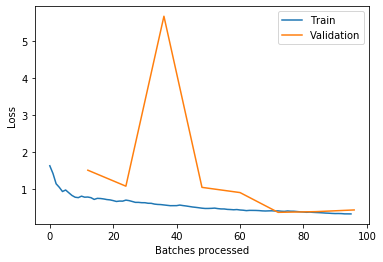

f18_224_lr_0.01_cyc_8_i2


Better model found at epoch 0 with accuracy value: 0.6752136945724487.
Better model found at epoch 2 with accuracy value: 0.7094017267227173.
Better model found at epoch 3 with accuracy value: 0.8632478713989258.


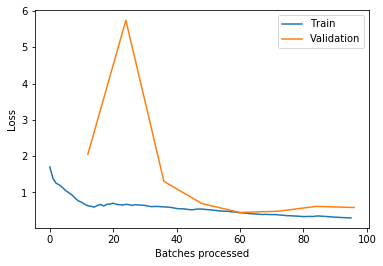

f18_224_lr_0.01_cyc_8_i3


Better model found at epoch 0 with accuracy value: 0.7649572491645813.
Better model found at epoch 2 with accuracy value: 0.811965823173523.
Better model found at epoch 4 with accuracy value: 0.8846153616905212.


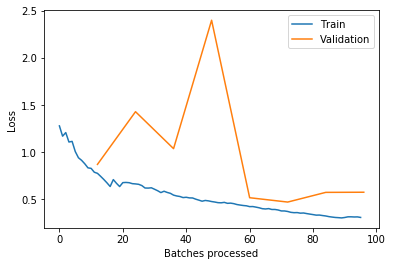

f18_224_lr_0.01_cyc_8_i4


Better model found at epoch 0 with accuracy value: 0.7991452813148499.
Better model found at epoch 4 with accuracy value: 0.8376068472862244.
Better model found at epoch 5 with accuracy value: 0.8974359035491943.


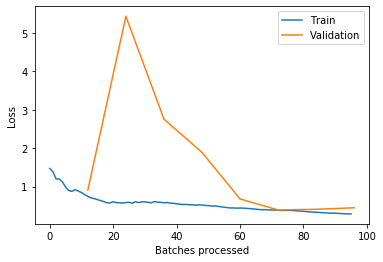

f18_224_lr_0.01_cyc_8_i5


Better model found at epoch 0 with accuracy value: 0.747863233089447.
Better model found at epoch 1 with accuracy value: 0.8547008633613586.
Better model found at epoch 2 with accuracy value: 0.867521345615387.
Better model found at epoch 6 with accuracy value: 0.8931623697280884.


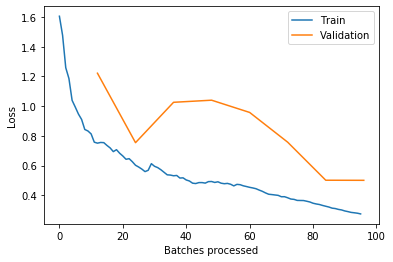

f18_224_lr_0.01_cyc_8_i6


Better model found at epoch 0 with accuracy value: 0.7350427508354187.
Better model found at epoch 2 with accuracy value: 0.7863247990608215.
Better model found at epoch 3 with accuracy value: 0.8034188151359558.
Better model found at epoch 4 with accuracy value: 0.8333333134651184.
Better model found at epoch 5 with accuracy value: 0.8589743375778198.
Better model found at epoch 7 with accuracy value: 0.8717948794364929.


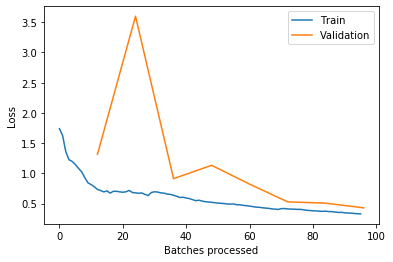

f18_224_lr_0.01_cyc_8_i7


Better model found at epoch 0 with accuracy value: 0.7948718070983887.
Better model found at epoch 2 with accuracy value: 0.8162392973899841.
Better model found at epoch 3 with accuracy value: 0.9059829115867615.


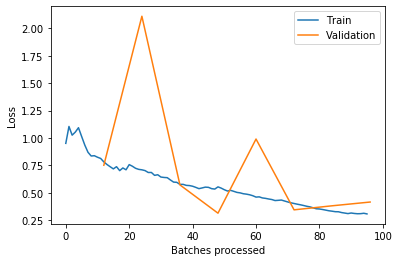

f18_224_lr_0.01_cyc_8_i8


Better model found at epoch 0 with accuracy value: 0.7094017267227173.
Better model found at epoch 4 with accuracy value: 0.7649572491645813.
Better model found at epoch 5 with accuracy value: 0.8589743375778198.
Better model found at epoch 6 with accuracy value: 0.8632478713989258.


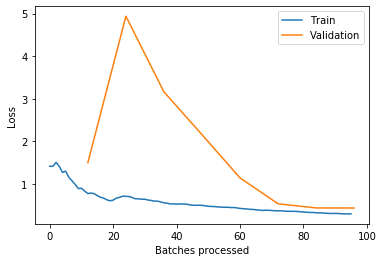

f18_224_lr_0.01_cyc_8_i9


Better model found at epoch 0 with accuracy value: 0.5683760643005371.
Better model found at epoch 2 with accuracy value: 0.7264957427978516.
Better model found at epoch 4 with accuracy value: 0.8162392973899841.
Better model found at epoch 7 with accuracy value: 0.8333333134651184.


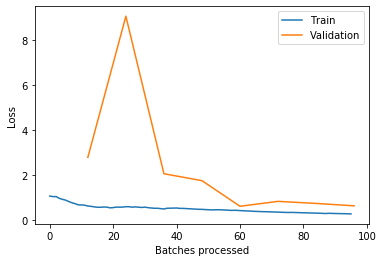

saved stats to: stats/f18_224_stats.p


In [30]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [31]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.081  med: 0.147   Loss -- best: 0.267  med: 0.473

f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_8_i4  error_rate: 0.103   accuracy: 0.897   loss:0.3919
f18_224_lr_0.01_cyc_8_i5  error_rate: 0.107   accuracy: 0.893   loss:0.5016
f18_224_lr_0.01_cyc_8_i3  error_rate: 0.115   accuracy: 0.885   loss:0.4712
f18_224_lr_0.0003_cyc_8  error_rate: 0.115   accuracy: 0.885   loss:0.4228
f18_224_lr_0.01_cyc_8_i1  error_rate: 0.120   accuracy: 0.880   loss:0.3805
f18_224_lr_0.001_cyc_16_ps_0.5  error_rate: 0.120   accuracy: 0.880   loss:0.4101
f18_224_lr_0.0001_cyc_16_ps_0.8  error_rate: 0.120   accuracy: 0.880   loss:0.4313


f18_224_lr_0.01_cyc_4_i0


Better model found at epoch 0 with accuracy value: 0.8504273295402527.


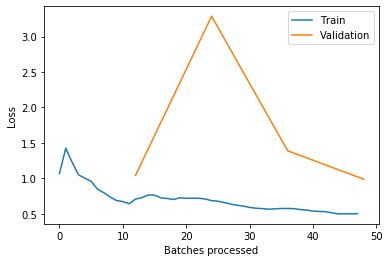

f18_224_lr_0.01_cyc_4_i1


Better model found at epoch 0 with accuracy value: 0.5512820482254028.
Better model found at epoch 1 with accuracy value: 0.8162392973899841.


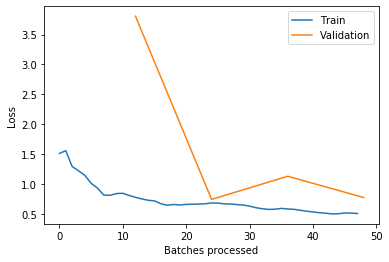

f18_224_lr_0.01_cyc_4_i2


Better model found at epoch 0 with accuracy value: 0.8461538553237915.


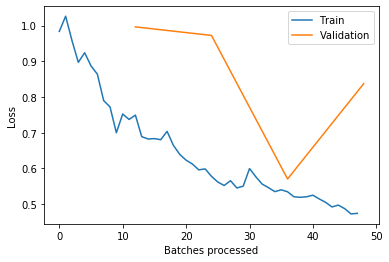

f18_224_lr_0.01_cyc_4_i3


Better model found at epoch 0 with accuracy value: 0.7692307829856873.
Better model found at epoch 1 with accuracy value: 0.8376068472862244.


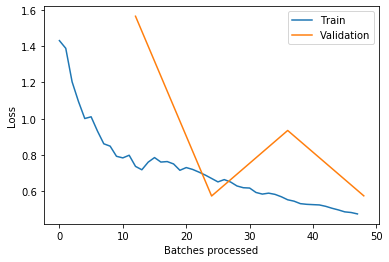

f18_224_lr_0.01_cyc_4_i4


Better model found at epoch 0 with accuracy value: 0.811965823173523.


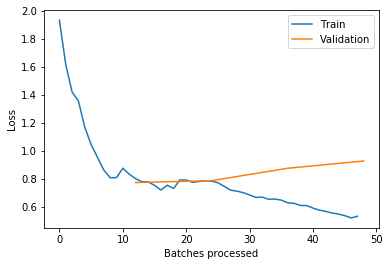

f18_224_lr_0.01_cyc_4_i5


Better model found at epoch 0 with accuracy value: 0.632478654384613.
Better model found at epoch 1 with accuracy value: 0.6495726704597473.
Better model found at epoch 3 with accuracy value: 0.7606837749481201.


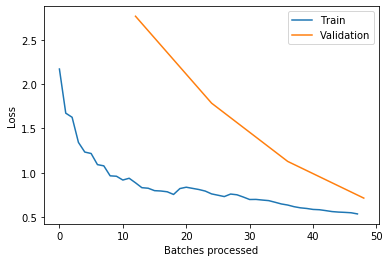

f18_224_lr_0.01_cyc_4_i6


Better model found at epoch 0 with accuracy value: 0.5641025900840759.
Better model found at epoch 1 with accuracy value: 0.807692289352417.
Better model found at epoch 3 with accuracy value: 0.811965823173523.


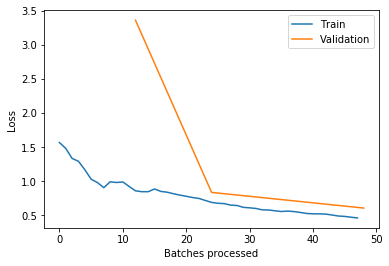

f18_224_lr_0.01_cyc_4_i7


Better model found at epoch 0 with accuracy value: 0.8247863054275513.


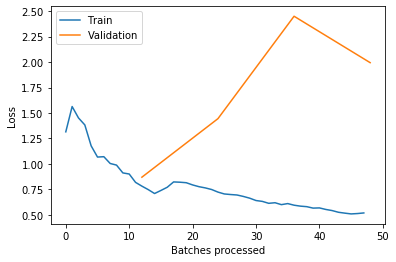

f18_224_lr_0.01_cyc_4_i8


Better model found at epoch 0 with accuracy value: 0.5982906222343445.
Better model found at epoch 1 with accuracy value: 0.632478654384613.
Better model found at epoch 2 with accuracy value: 0.7094017267227173.
Better model found at epoch 3 with accuracy value: 0.7735042572021484.


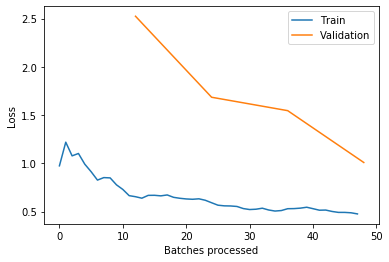

f18_224_lr_0.01_cyc_4_i9


Better model found at epoch 0 with accuracy value: 0.5854700803756714.
Better model found at epoch 2 with accuracy value: 0.6068376302719116.
Better model found at epoch 3 with accuracy value: 0.6623931527137756.


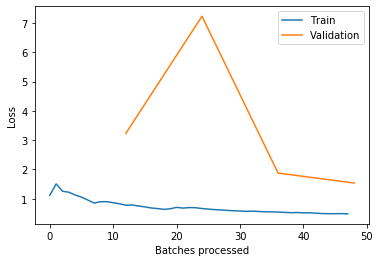

saved stats to: stats/f18_224_stats.p


In [32]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [33]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.081  med: 0.158   Loss -- best: 0.267  med: 0.519

f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_8_i4  error_rate: 0.103   accuracy: 0.897   loss:0.3919
f18_224_lr_0.01_cyc_8_i5  error_rate: 0.107   accuracy: 0.893   loss:0.5016
f18_224_lr_0.01_cyc_8_i3  error_rate: 0.115   accuracy: 0.885   loss:0.4712
f18_224_lr_0.0003_cyc_8  error_rate: 0.115   accuracy: 0.885   loss:0.4228
f18_224_lr_0.01_cyc_8_i1  error_rate: 0.120   accuracy: 0.880   loss:0.3805
f18_224_lr_0.001_cyc_16_ps_0.5  error_rate: 0.120   accuracy: 0.880   loss:0.4101
f18_224_lr_0.0001_cyc_16_ps_0.8  error_rate: 0.120   accuracy: 0.880   loss:0.4313


f18_224_lr_0.01_cyc_12_i0


Better model found at epoch 0 with accuracy value: 0.7435897588729858.
Better model found at epoch 5 with accuracy value: 0.8376068472862244.
Better model found at epoch 6 with accuracy value: 0.8974359035491943.
Better model found at epoch 8 with accuracy value: 0.9017093777656555.
Better model found at epoch 9 with accuracy value: 0.9145299196243286.
Better model found at epoch 11 with accuracy value: 0.9230769276618958.


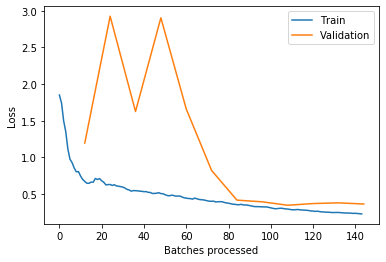

f18_224_lr_0.01_cyc_12_i1


Better model found at epoch 0 with accuracy value: 0.7820512652397156.
Better model found at epoch 2 with accuracy value: 0.8461538553237915.


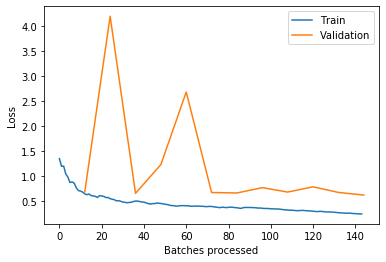

f18_224_lr_0.01_cyc_12_i2


Better model found at epoch 0 with accuracy value: 0.7905982732772827.
Better model found at epoch 4 with accuracy value: 0.8290598392486572.
Better model found at epoch 5 with accuracy value: 0.867521345615387.
Better model found at epoch 6 with accuracy value: 0.9017093777656555.


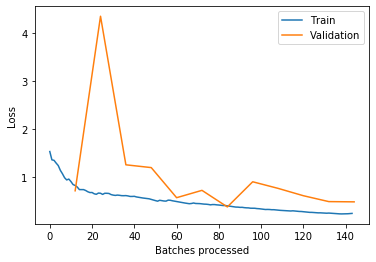

f18_224_lr_0.01_cyc_12_i3


Better model found at epoch 0 with accuracy value: 0.6837607026100159.
Better model found at epoch 2 with accuracy value: 0.7094017267227173.
Better model found at epoch 3 with accuracy value: 0.7350427508354187.
Better model found at epoch 4 with accuracy value: 0.7991452813148499.
Better model found at epoch 5 with accuracy value: 0.8205128312110901.
Better model found at epoch 6 with accuracy value: 0.8333333134651184.
Better model found at epoch 7 with accuracy value: 0.8846153616905212.
Better model found at epoch 9 with accuracy value: 0.9059829115867615.


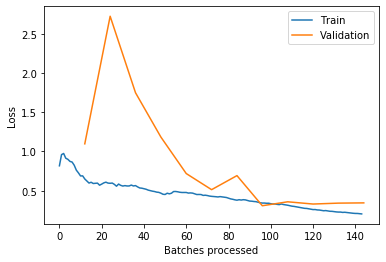

f18_224_lr_0.01_cyc_12_i4


Better model found at epoch 0 with accuracy value: 0.8632478713989258.
Better model found at epoch 3 with accuracy value: 0.867521345615387.
Better model found at epoch 5 with accuracy value: 0.8717948794364929.
Better model found at epoch 6 with accuracy value: 0.9059829115867615.
Better model found at epoch 7 with accuracy value: 0.9358974099159241.


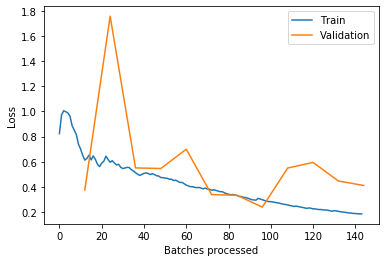

f18_224_lr_0.01_cyc_12_i5


Better model found at epoch 0 with accuracy value: 0.7435897588729858.
Better model found at epoch 4 with accuracy value: 0.7606837749481201.
Better model found at epoch 5 with accuracy value: 0.9017093777656555.
Better model found at epoch 7 with accuracy value: 0.9188033938407898.


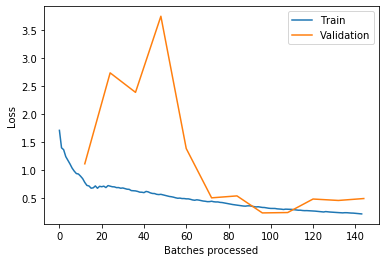

f18_224_lr_0.01_cyc_12_i6


Better model found at epoch 0 with accuracy value: 0.7393162250518799.
Better model found at epoch 2 with accuracy value: 0.8504273295402527.
Better model found at epoch 4 with accuracy value: 0.8632478713989258.
Better model found at epoch 5 with accuracy value: 0.8888888955116272.
Better model found at epoch 8 with accuracy value: 0.8974359035491943.


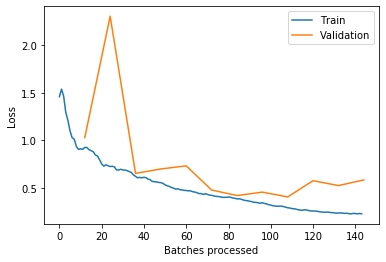

f18_224_lr_0.01_cyc_12_i7


Better model found at epoch 0 with accuracy value: 0.7820512652397156.
Better model found at epoch 3 with accuracy value: 0.8247863054275513.
Better model found at epoch 4 with accuracy value: 0.8717948794364929.
Better model found at epoch 5 with accuracy value: 0.8803418874740601.
Better model found at epoch 6 with accuracy value: 0.9188033938407898.
Better model found at epoch 8 with accuracy value: 0.9316239356994629.


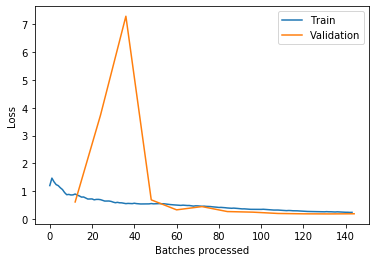

f18_224_lr_0.01_cyc_12_i8


Better model found at epoch 0 with accuracy value: 0.8632478713989258.
Better model found at epoch 10 with accuracy value: 0.8803418874740601.


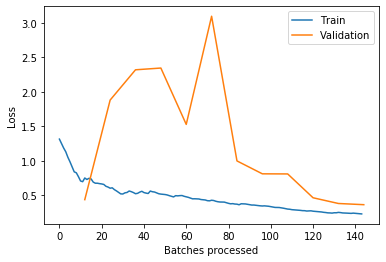

f18_224_lr_0.01_cyc_12_i9


Better model found at epoch 0 with accuracy value: 0.7136752009391785.
Better model found at epoch 4 with accuracy value: 0.8376068472862244.
Better model found at epoch 5 with accuracy value: 0.867521345615387.
Better model found at epoch 6 with accuracy value: 0.8846153616905212.
Better model found at epoch 7 with accuracy value: 0.9059829115867615.


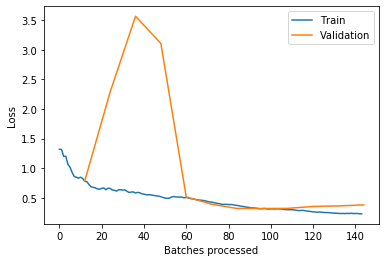

saved stats to: stats/f18_224_stats.p


In [34]:
for i in range(10):
    for key, params in get_params(all_cycles=[12], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [35]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.150   Loss -- best: 0.209  med: 0.480

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167
f18_224_lr_0.01_cyc_12_i2  error_rate: 0.098   accuracy: 0.902   loss:0.3682


f18_224_lr_0.02_cyc_8_i0


Better model found at epoch 0 with accuracy value: 0.6965811848640442.
Better model found at epoch 2 with accuracy value: 0.8162392377853394.
Better model found at epoch 4 with accuracy value: 0.8333333134651184.


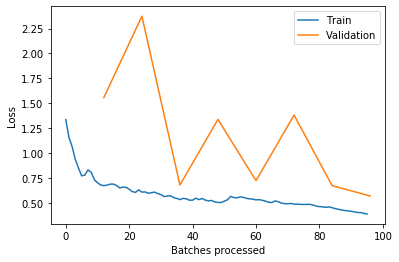

f18_224_lr_0.02_cyc_8_i1


Better model found at epoch 0 with accuracy value: 0.6239316463470459.
Better model found at epoch 4 with accuracy value: 0.8504273295402527.


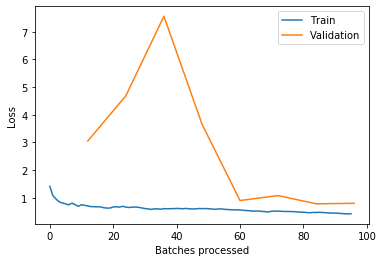

f18_224_lr_0.02_cyc_8_i2


Better model found at epoch 0 with accuracy value: 0.692307710647583.
Better model found at epoch 1 with accuracy value: 0.6965811848640442.
Better model found at epoch 2 with accuracy value: 0.7692307829856873.
Better model found at epoch 3 with accuracy value: 0.8162392973899841.
Better model found at epoch 5 with accuracy value: 0.8205128312110901.
Better model found at epoch 6 with accuracy value: 0.8760683536529541.


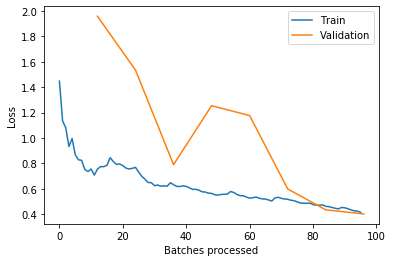

f18_224_lr_0.02_cyc_8_i3


Better model found at epoch 0 with accuracy value: 0.7179487347602844.
Better model found at epoch 3 with accuracy value: 0.8717948794364929.
Better model found at epoch 5 with accuracy value: 0.8931623697280884.


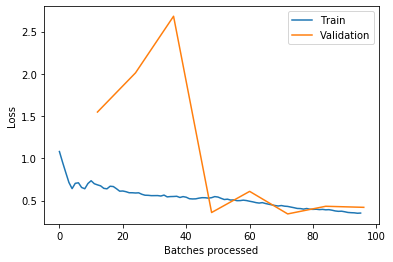

f18_224_lr_0.02_cyc_8_i4


Better model found at epoch 0 with accuracy value: 0.7735041975975037.
Better model found at epoch 4 with accuracy value: 0.7905982732772827.
Better model found at epoch 5 with accuracy value: 0.8504273295402527.


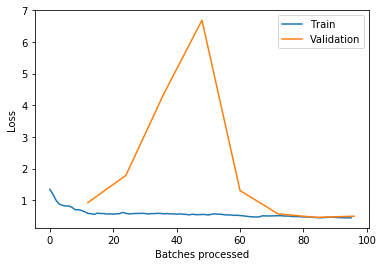

f18_224_lr_0.02_cyc_8_i5


Better model found at epoch 0 with accuracy value: 0.5726495981216431.
Better model found at epoch 1 with accuracy value: 0.6367521286010742.
Better model found at epoch 2 with accuracy value: 0.8461538553237915.
Better model found at epoch 6 with accuracy value: 0.867521345615387.
Better model found at epoch 7 with accuracy value: 0.8717948794364929.


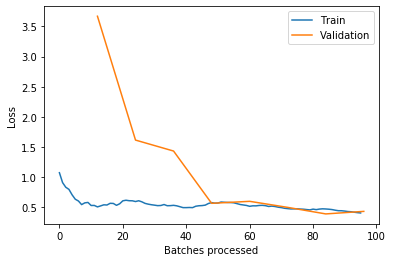

f18_224_lr_0.02_cyc_8_i6


Better model found at epoch 0 with accuracy value: 0.7307692170143127.
Better model found at epoch 1 with accuracy value: 0.7350427508354187.
Better model found at epoch 4 with accuracy value: 0.8547008633613586.
Better model found at epoch 6 with accuracy value: 0.8803418874740601.


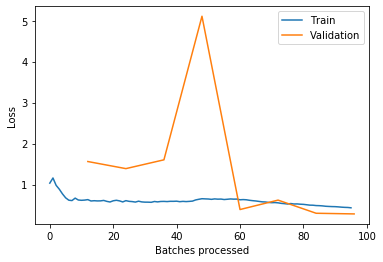

f18_224_lr_0.02_cyc_8_i7


Better model found at epoch 0 with accuracy value: 0.752136766910553.
Better model found at epoch 5 with accuracy value: 0.8247863054275513.
Better model found at epoch 6 with accuracy value: 0.8461538553237915.
Better model found at epoch 7 with accuracy value: 0.867521345615387.


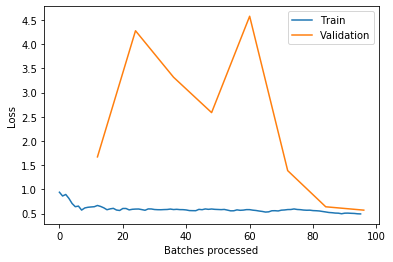

f18_224_lr_0.02_cyc_8_i8


Better model found at epoch 0 with accuracy value: 0.7222222089767456.
Better model found at epoch 3 with accuracy value: 0.807692289352417.
Better model found at epoch 4 with accuracy value: 0.8247863054275513.
Better model found at epoch 5 with accuracy value: 0.8589743375778198.
Better model found at epoch 6 with accuracy value: 0.8846153616905212.


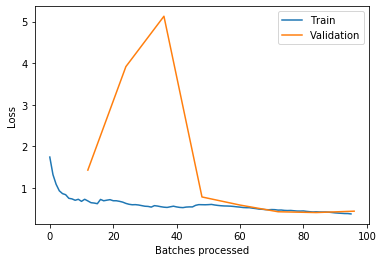

f18_224_lr_0.02_cyc_8_i9


Better model found at epoch 0 with accuracy value: 0.5299145579338074.
Better model found at epoch 2 with accuracy value: 0.7820512652397156.
Better model found at epoch 3 with accuracy value: 0.8205128312110901.
Better model found at epoch 4 with accuracy value: 0.8931623697280884.


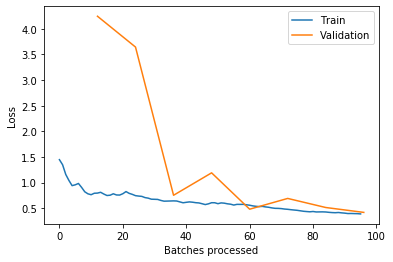

saved stats to: stats/f18_224_stats.p


In [36]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [37]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.145   Loss -- best: 0.209  med: 0.473

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167
f18_224_lr_0.01_cyc_12_i2  error_rate: 0.098   accuracy: 0.902   loss:0.3682


f18_224_lr_0.02_cyc_4_i0


Better model found at epoch 0 with accuracy value: 0.7136752009391785.
Better model found at epoch 1 with accuracy value: 0.8547008633613586.
Better model found at epoch 3 with accuracy value: 0.8717948794364929.


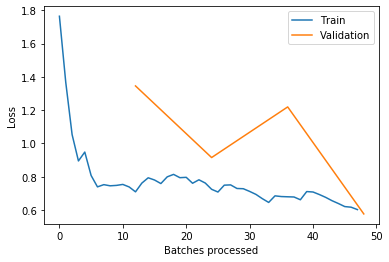

f18_224_lr_0.02_cyc_4_i1


Better model found at epoch 0 with accuracy value: 0.5042734742164612.
Better model found at epoch 2 with accuracy value: 0.6196581125259399.
Better model found at epoch 3 with accuracy value: 0.8418803215026855.


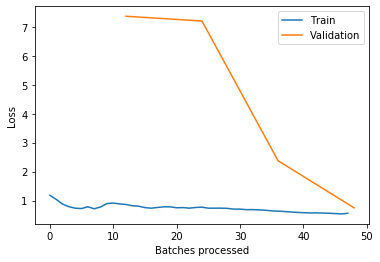

f18_224_lr_0.02_cyc_4_i2


Better model found at epoch 0 with accuracy value: 0.8376068472862244.


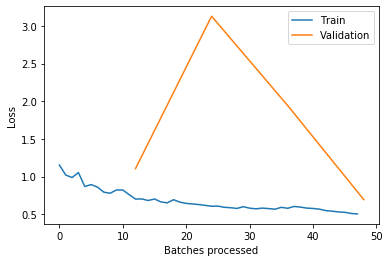

f18_224_lr_0.02_cyc_4_i3


Better model found at epoch 0 with accuracy value: 0.7393162250518799.
Better model found at epoch 3 with accuracy value: 0.8290598392486572.


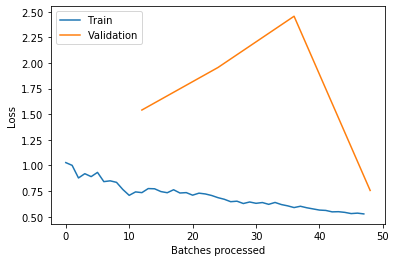

f18_224_lr_0.02_cyc_4_i4


Better model found at epoch 0 with accuracy value: 0.747863233089447.
Better model found at epoch 2 with accuracy value: 0.7777777910232544.
Better model found at epoch 3 with accuracy value: 0.8760683536529541.


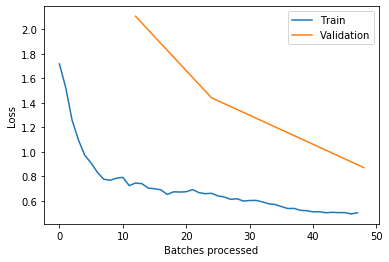

f18_224_lr_0.02_cyc_4_i5


Better model found at epoch 0 with accuracy value: 0.5170940160751343.
Better model found at epoch 1 with accuracy value: 0.6068376302719116.
Better model found at epoch 2 with accuracy value: 0.7991452813148499.
Better model found at epoch 3 with accuracy value: 0.8162392973899841.


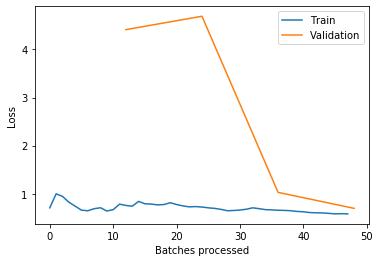

f18_224_lr_0.02_cyc_4_i6


Better model found at epoch 0 with accuracy value: 0.8247863054275513.
Better model found at epoch 2 with accuracy value: 0.8589743375778198.


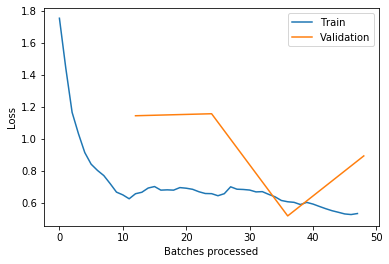

f18_224_lr_0.02_cyc_4_i7


Better model found at epoch 0 with accuracy value: 0.7264957427978516.
Better model found at epoch 2 with accuracy value: 0.8547008633613586.


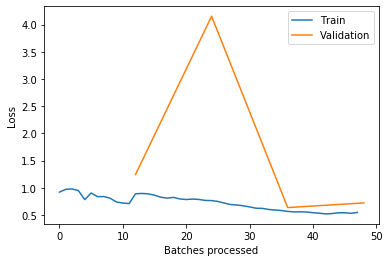

f18_224_lr_0.02_cyc_4_i8


Better model found at epoch 0 with accuracy value: 0.8589743375778198.


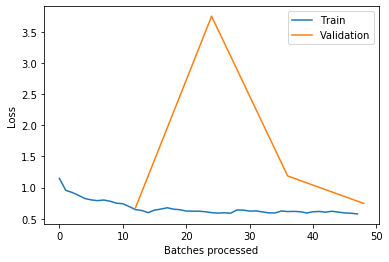

f18_224_lr_0.02_cyc_4_i9


Better model found at epoch 0 with accuracy value: 0.6239316463470459.
Better model found at epoch 2 with accuracy value: 0.811965823173523.
Better model found at epoch 3 with accuracy value: 0.8632478713989258.


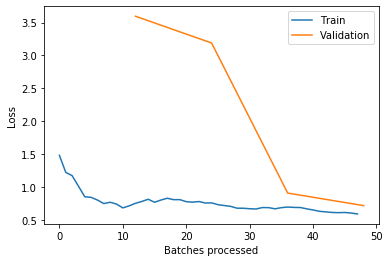

saved stats to: stats/f18_224_stats.p


In [38]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [39]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.145   Loss -- best: 0.209  med: 0.517

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167
f18_224_lr_0.01_cyc_12_i2  error_rate: 0.098   accuracy: 0.902   loss:0.3682


f18_224_lr_0.03_cyc_8_i0


Better model found at epoch 0 with accuracy value: 0.6837607026100159.
Better model found at epoch 2 with accuracy value: 0.692307710647583.
Better model found at epoch 3 with accuracy value: 0.7649572491645813.
Better model found at epoch 4 with accuracy value: 0.8034188151359558.
Better model found at epoch 5 with accuracy value: 0.8376068472862244.
Better model found at epoch 6 with accuracy value: 0.8803418874740601.
Better model found at epoch 7 with accuracy value: 0.8846153616905212.


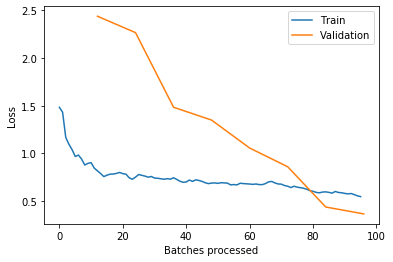

f18_224_lr_0.03_cyc_8_i1


Better model found at epoch 0 with accuracy value: 0.6495726704597473.
Better model found at epoch 2 with accuracy value: 0.7136752009391785.
Better model found at epoch 4 with accuracy value: 0.7307692170143127.
Better model found at epoch 5 with accuracy value: 0.7692307829856873.


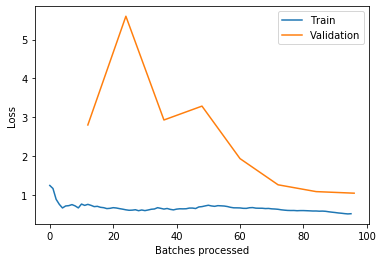

f18_224_lr_0.03_cyc_8_i2


Better model found at epoch 0 with accuracy value: 0.5170940160751343.
Better model found at epoch 2 with accuracy value: 0.6196581125259399.
Better model found at epoch 4 with accuracy value: 0.8162392973899841.
Better model found at epoch 6 with accuracy value: 0.8333333134651184.


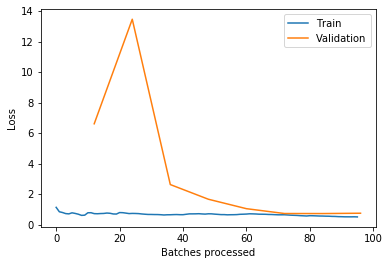

f18_224_lr_0.03_cyc_8_i3


Better model found at epoch 0 with accuracy value: 0.8205128312110901.
Better model found at epoch 4 with accuracy value: 0.8247863054275513.
Better model found at epoch 5 with accuracy value: 0.8333333134651184.
Better model found at epoch 6 with accuracy value: 0.8504273295402527.


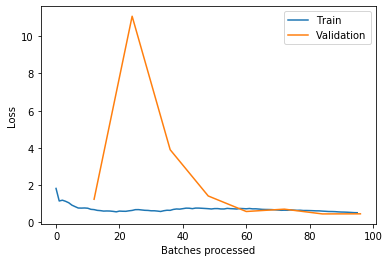

f18_224_lr_0.03_cyc_8_i4


Better model found at epoch 0 with accuracy value: 0.5470085740089417.
Better model found at epoch 1 with accuracy value: 0.7051281929016113.
Better model found at epoch 3 with accuracy value: 0.8418803215026855.


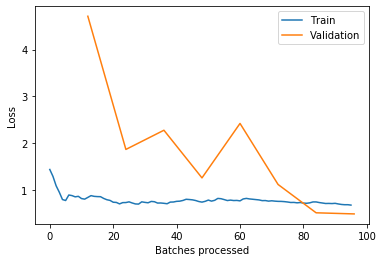

f18_224_lr_0.03_cyc_8_i5


Better model found at epoch 0 with accuracy value: 0.7863247990608215.
Better model found at epoch 5 with accuracy value: 0.8034188151359558.
Better model found at epoch 6 with accuracy value: 0.8760683536529541.


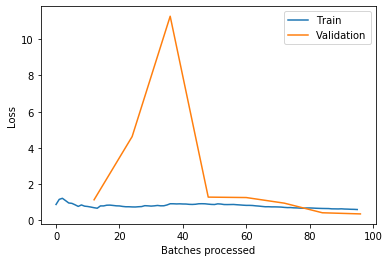

f18_224_lr_0.03_cyc_8_i6


Better model found at epoch 0 with accuracy value: 0.504273533821106.
Better model found at epoch 2 with accuracy value: 0.6452991366386414.
Better model found at epoch 3 with accuracy value: 0.6965811848640442.
Better model found at epoch 5 with accuracy value: 0.7564102411270142.
Better model found at epoch 6 with accuracy value: 0.7692307829856873.
Better model found at epoch 7 with accuracy value: 0.8376068472862244.


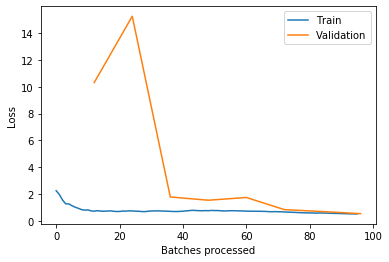

f18_224_lr_0.03_cyc_8_i7


Better model found at epoch 0 with accuracy value: 0.8205128312110901.


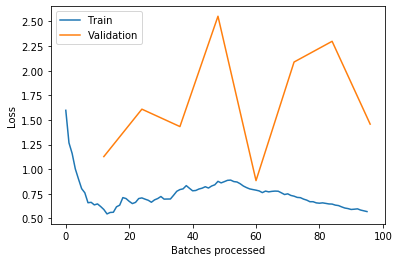

f18_224_lr_0.03_cyc_8_i8


Better model found at epoch 0 with accuracy value: 0.5854700803756714.
Better model found at epoch 1 with accuracy value: 0.7350427508354187.
Better model found at epoch 2 with accuracy value: 0.8162392973899841.
Better model found at epoch 5 with accuracy value: 0.8247863054275513.
Better model found at epoch 6 with accuracy value: 0.8418803215026855.
Better model found at epoch 7 with accuracy value: 0.8632478713989258.


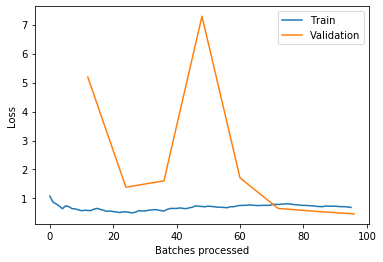

f18_224_lr_0.03_cyc_8_i9


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 4 with accuracy value: 0.8504273295402527.


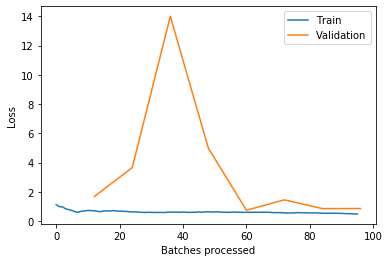

saved stats to: stats/f18_224_stats.p


In [40]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [41]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.147   Loss -- best: 0.209  med: 0.519

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167
f18_224_lr_0.01_cyc_12_i2  error_rate: 0.098   accuracy: 0.902   loss:0.3682


f18_224_lr_0.03_cyc_4_i0


Better model found at epoch 0 with accuracy value: 0.6965811848640442.
Better model found at epoch 2 with accuracy value: 0.7649572491645813.
Better model found at epoch 3 with accuracy value: 0.8247863054275513.


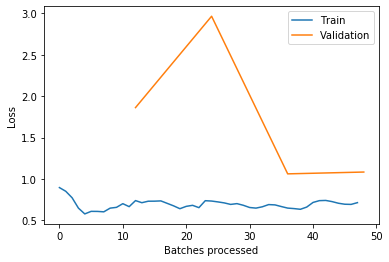

f18_224_lr_0.03_cyc_4_i1


Better model found at epoch 0 with accuracy value: 0.7863247990608215.


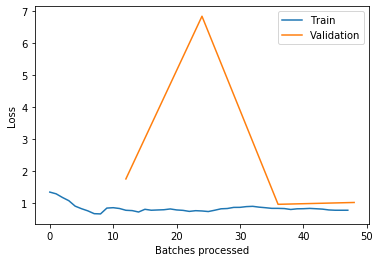

f18_224_lr_0.03_cyc_4_i2


Better model found at epoch 0 with accuracy value: 0.4999999701976776.
Better model found at epoch 1 with accuracy value: 0.5170940160751343.
Better model found at epoch 2 with accuracy value: 0.7564102411270142.


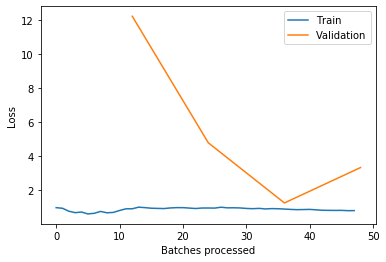

f18_224_lr_0.03_cyc_4_i3


Better model found at epoch 0 with accuracy value: 0.8247863054275513.


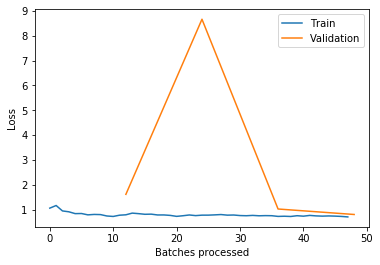

f18_224_lr_0.03_cyc_4_i4


Better model found at epoch 0 with accuracy value: 0.692307710647583.
Better model found at epoch 2 with accuracy value: 0.807692289352417.
Better model found at epoch 3 with accuracy value: 0.8162392973899841.


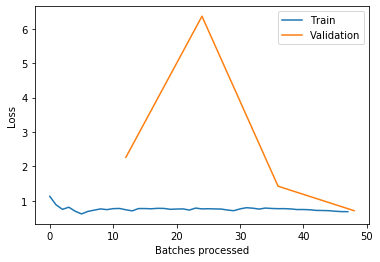

f18_224_lr_0.03_cyc_4_i5


Better model found at epoch 0 with accuracy value: 0.6367521286010742.
Better model found at epoch 1 with accuracy value: 0.6623931527137756.
Better model found at epoch 2 with accuracy value: 0.7264957427978516.
Better model found at epoch 3 with accuracy value: 0.8247863054275513.


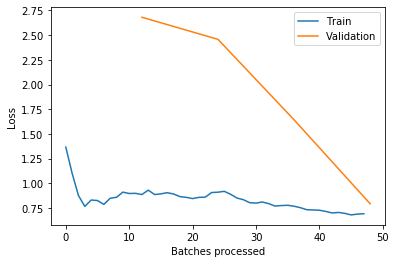

f18_224_lr_0.03_cyc_4_i6


Better model found at epoch 0 with accuracy value: 0.7393162250518799.
Better model found at epoch 2 with accuracy value: 0.752136766910553.
Better model found at epoch 3 with accuracy value: 0.807692289352417.


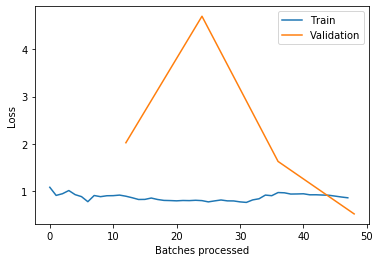

f18_224_lr_0.03_cyc_4_i7


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.7393162250518799.
Better model found at epoch 2 with accuracy value: 0.7905982732772827.


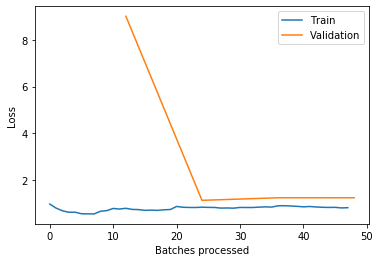

f18_224_lr_0.03_cyc_4_i8


Better model found at epoch 0 with accuracy value: 0.5256410241127014.
Better model found at epoch 1 with accuracy value: 0.5470085740089417.
Better model found at epoch 2 with accuracy value: 0.6837607026100159.
Better model found at epoch 3 with accuracy value: 0.8034188151359558.


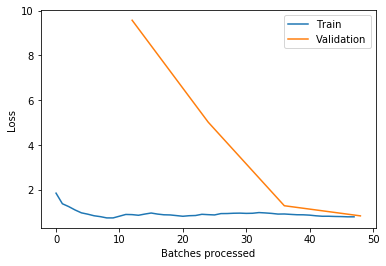

f18_224_lr_0.03_cyc_4_i9


Better model found at epoch 0 with accuracy value: 0.5042734742164612.
Better model found at epoch 1 with accuracy value: 0.6666666865348816.
Better model found at epoch 2 with accuracy value: 0.8034188151359558.


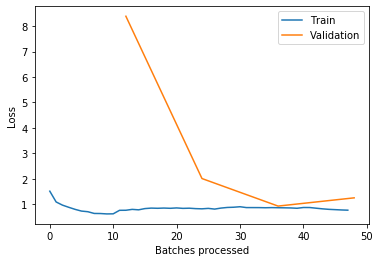

saved stats to: stats/f18_224_stats.p


In [42]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [43]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.150   Loss -- best: 0.209  med: 0.566

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167
f18_224_lr_0.01_cyc_12_i2  error_rate: 0.098   accuracy: 0.902   loss:0.3682


f18_224_lr_0.02_cyc_8_i0_m


Better model found at epoch 0 with accuracy value: 0.5641025900840759.
Better model found at epoch 2 with accuracy value: 0.6452991366386414.
Better model found at epoch 3 with accuracy value: 0.7948718070983887.
Better model found at epoch 4 with accuracy value: 0.8247863054275513.
Better model found at epoch 7 with accuracy value: 0.8290598392486572.


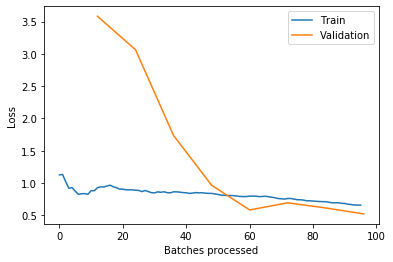

f18_224_lr_0.02_cyc_8_i1_m


Better model found at epoch 0 with accuracy value: 0.6282051205635071.
Better model found at epoch 1 with accuracy value: 0.7008547186851501.
Better model found at epoch 4 with accuracy value: 0.7777777910232544.
Better model found at epoch 5 with accuracy value: 0.7948718070983887.
Better model found at epoch 6 with accuracy value: 0.8290598392486572.
Better model found at epoch 7 with accuracy value: 0.8418803215026855.


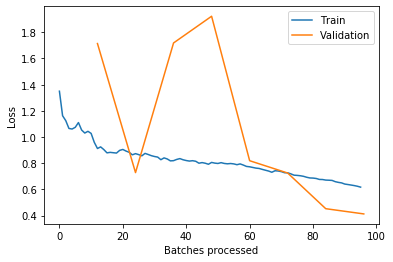

f18_224_lr_0.02_cyc_8_i2_m


Better model found at epoch 0 with accuracy value: 0.8205128312110901.
Better model found at epoch 5 with accuracy value: 0.8547008633613586.


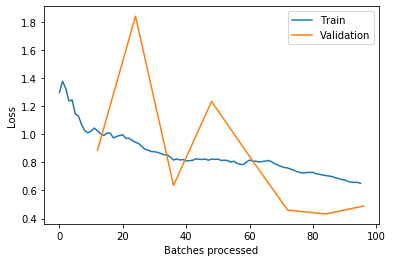

f18_224_lr_0.02_cyc_8_i3_m


Better model found at epoch 0 with accuracy value: 0.8205128312110901.


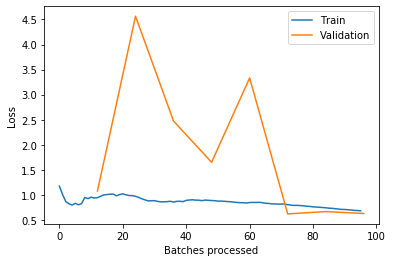

f18_224_lr_0.02_cyc_8_i4_m


Better model found at epoch 0 with accuracy value: 0.6196581125259399.
Better model found at epoch 2 with accuracy value: 0.7094017267227173.
Better model found at epoch 3 with accuracy value: 0.7136752009391785.
Better model found at epoch 5 with accuracy value: 0.7350427508354187.
Better model found at epoch 6 with accuracy value: 0.8589743375778198.
Better model found at epoch 7 with accuracy value: 0.8760683536529541.


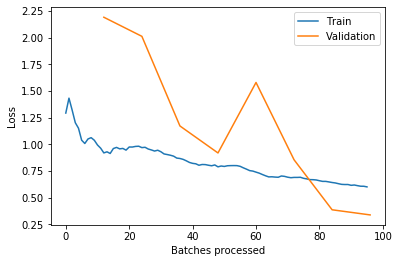

f18_224_lr_0.02_cyc_8_i5_m


Better model found at epoch 0 with accuracy value: 0.5128205418586731.
Better model found at epoch 1 with accuracy value: 0.6581196784973145.
Better model found at epoch 2 with accuracy value: 0.7991452813148499.
Better model found at epoch 5 with accuracy value: 0.8547008633613586.
Better model found at epoch 7 with accuracy value: 0.8589743375778198.


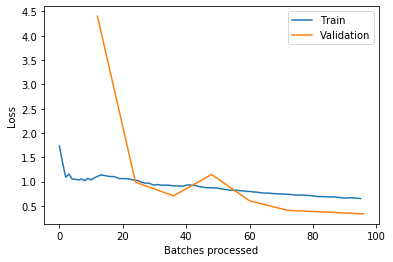

f18_224_lr_0.02_cyc_8_i6_m


Better model found at epoch 0 with accuracy value: 0.5256410241127014.
Better model found at epoch 1 with accuracy value: 0.6837607026100159.
Better model found at epoch 4 with accuracy value: 0.7905982732772827.
Better model found at epoch 5 with accuracy value: 0.8162392973899841.
Better model found at epoch 6 with accuracy value: 0.8247863054275513.
Better model found at epoch 7 with accuracy value: 0.8504273295402527.


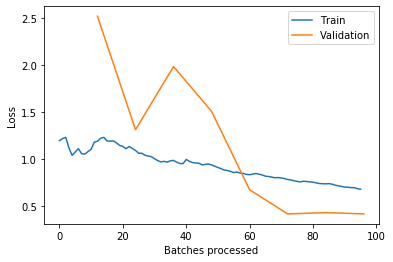

f18_224_lr_0.02_cyc_8_i7_m


Better model found at epoch 0 with accuracy value: 0.5128205418586731.
Better model found at epoch 1 with accuracy value: 0.7435897588729858.
Better model found at epoch 3 with accuracy value: 0.7863247990608215.
Better model found at epoch 4 with accuracy value: 0.8461538553237915.


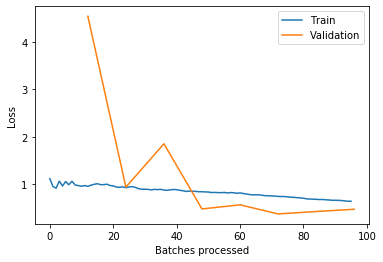

f18_224_lr_0.02_cyc_8_i8_m


Better model found at epoch 0 with accuracy value: 0.5769230723381042.
Better model found at epoch 1 with accuracy value: 0.7692307829856873.
Better model found at epoch 2 with accuracy value: 0.7905982732772827.
Better model found at epoch 7 with accuracy value: 0.8333333134651184.


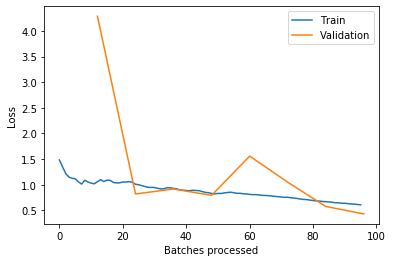

f18_224_lr_0.02_cyc_8_i9_m


Better model found at epoch 0 with accuracy value: 0.6452991366386414.
Better model found at epoch 3 with accuracy value: 0.7307692170143127.
Better model found at epoch 4 with accuracy value: 0.8247863054275513.


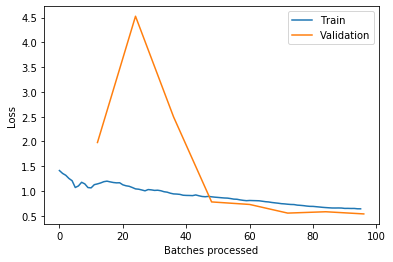

saved stats to: stats/f18_224_stats.p


In [44]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [45]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.152   Loss -- best: 0.209  med: 0.550

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167
f18_224_lr_0.01_cyc_12_i2  error_rate: 0.098   accuracy: 0.902   loss:0.3682


f18_224_lr_0.02_cyc_16_i0_m


Better model found at epoch 0 with accuracy value: 0.6581196784973145.
Better model found at epoch 7 with accuracy value: 0.7649572491645813.
Better model found at epoch 8 with accuracy value: 0.8888888955116272.


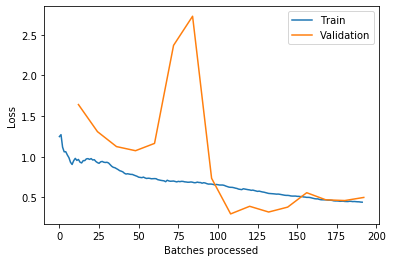

f18_224_lr_0.02_cyc_16_i1_m


Better model found at epoch 0 with accuracy value: 0.6239316463470459.
Better model found at epoch 2 with accuracy value: 0.6623931527137756.
Better model found at epoch 3 with accuracy value: 0.7008547186851501.
Better model found at epoch 4 with accuracy value: 0.8333333134651184.
Better model found at epoch 8 with accuracy value: 0.9059829115867615.


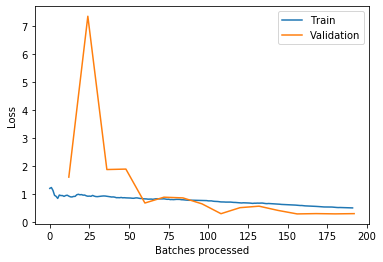

f18_224_lr_0.02_cyc_16_i2_m


Better model found at epoch 0 with accuracy value: 0.7777777910232544.
Better model found at epoch 5 with accuracy value: 0.7948718070983887.
Better model found at epoch 6 with accuracy value: 0.8247863054275513.
Better model found at epoch 11 with accuracy value: 0.8589743375778198.
Better model found at epoch 12 with accuracy value: 0.8632478713989258.
Better model found at epoch 13 with accuracy value: 0.867521345615387.


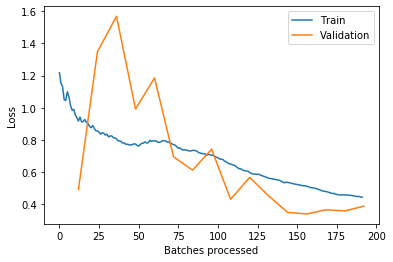

f18_224_lr_0.02_cyc_16_i3_m


Better model found at epoch 0 with accuracy value: 0.5384615659713745.
Better model found at epoch 1 with accuracy value: 0.7222222089767456.
Better model found at epoch 2 with accuracy value: 0.7307692170143127.
Better model found at epoch 3 with accuracy value: 0.8418803215026855.
Better model found at epoch 9 with accuracy value: 0.8589743375778198.


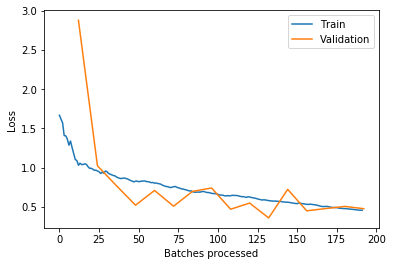

f18_224_lr_0.02_cyc_16_i4_m


Better model found at epoch 0 with accuracy value: 0.5213675498962402.
Better model found at epoch 1 with accuracy value: 0.5470085740089417.
Better model found at epoch 2 with accuracy value: 0.807692289352417.
Better model found at epoch 6 with accuracy value: 0.8589743375778198.
Better model found at epoch 9 with accuracy value: 0.8803418874740601.
Better model found at epoch 10 with accuracy value: 0.8846153616905212.
Better model found at epoch 12 with accuracy value: 0.9017093777656555.


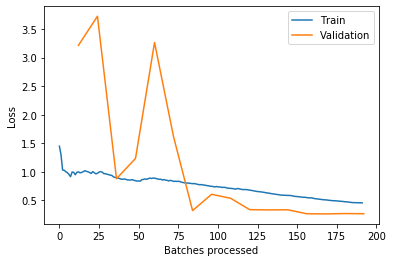

f18_224_lr_0.02_cyc_16_i5_m


Better model found at epoch 0 with accuracy value: 0.7649572491645813.
Better model found at epoch 6 with accuracy value: 0.8418803215026855.


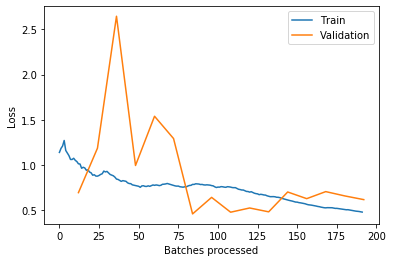

f18_224_lr_0.02_cyc_16_i6_m


Better model found at epoch 0 with accuracy value: 0.7777777910232544.
Better model found at epoch 3 with accuracy value: 0.8034188151359558.
Better model found at epoch 5 with accuracy value: 0.8162392973899841.
Better model found at epoch 6 with accuracy value: 0.8418803215026855.
Better model found at epoch 10 with accuracy value: 0.8931623697280884.


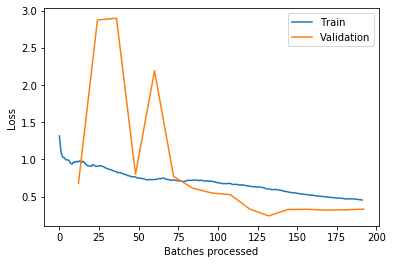

f18_224_lr_0.02_cyc_16_i7_m


Better model found at epoch 0 with accuracy value: 0.8504273295402527.
Better model found at epoch 10 with accuracy value: 0.8760683536529541.
Better model found at epoch 12 with accuracy value: 0.8803418874740601.
Better model found at epoch 14 with accuracy value: 0.8846153616905212.


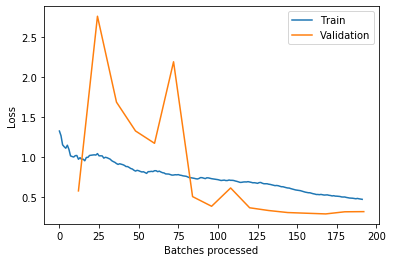

f18_224_lr_0.02_cyc_16_i8_m


Better model found at epoch 0 with accuracy value: 0.7735042572021484.
Better model found at epoch 5 with accuracy value: 0.7777777910232544.
Better model found at epoch 13 with accuracy value: 0.7905982732772827.


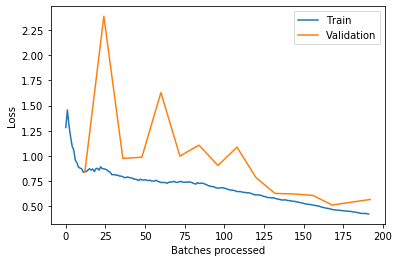

f18_224_lr_0.02_cyc_16_i9_m


Better model found at epoch 0 with accuracy value: 0.5170940160751343.
Better model found at epoch 2 with accuracy value: 0.7350427508354187.
Better model found at epoch 5 with accuracy value: 0.7564102411270142.
Better model found at epoch 9 with accuracy value: 0.8547008633613586.
Better model found at epoch 12 with accuracy value: 0.8760683536529541.


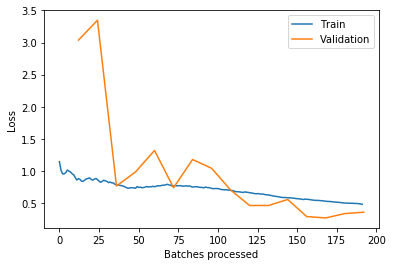

saved stats to: stats/f18_224_stats.p


In [46]:
for i in range(10):
    for key, params in get_params(all_cycles=[16], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [47]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.150   Loss -- best: 0.209  med: 0.517

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.094   accuracy: 0.906   loss:0.2941
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167


f18_224_lr_0.03_cyc_8_i0_m


Better model found at epoch 0 with accuracy value: 0.6965811848640442.
Better model found at epoch 4 with accuracy value: 0.7692307829856873.
Better model found at epoch 6 with accuracy value: 0.7820512652397156.
Better model found at epoch 7 with accuracy value: 0.8162392973899841.


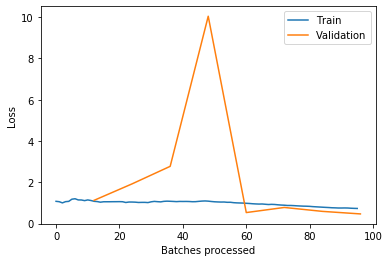

f18_224_lr_0.03_cyc_8_i1_m


Better model found at epoch 0 with accuracy value: 0.6367521286010742.
Better model found at epoch 2 with accuracy value: 0.7649572491645813.
Better model found at epoch 3 with accuracy value: 0.8632478713989258.


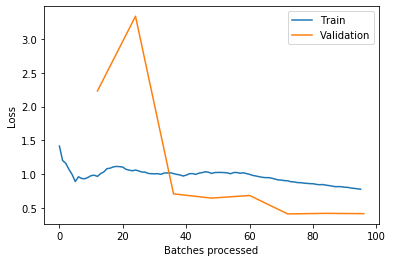

f18_224_lr_0.03_cyc_8_i2_m


Better model found at epoch 0 with accuracy value: 0.7991452813148499.
Better model found at epoch 4 with accuracy value: 0.8205128312110901.
Better model found at epoch 5 with accuracy value: 0.8290598392486572.


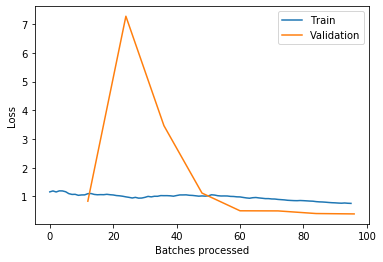

f18_224_lr_0.03_cyc_8_i3_m


Better model found at epoch 0 with accuracy value: 0.752136766910553.
Better model found at epoch 3 with accuracy value: 0.7948718070983887.
Better model found at epoch 4 with accuracy value: 0.8290598392486572.


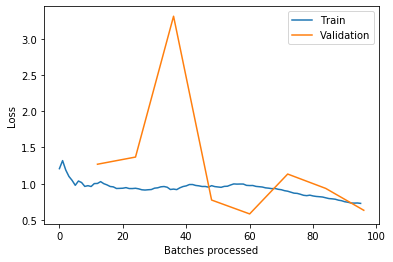

f18_224_lr_0.03_cyc_8_i4_m


Better model found at epoch 0 with accuracy value: 0.5384615659713745.
Better model found at epoch 2 with accuracy value: 0.6196580529212952.
Better model found at epoch 3 with accuracy value: 0.7692307829856873.
Better model found at epoch 6 with accuracy value: 0.7735042572021484.
Better model found at epoch 7 with accuracy value: 0.7948718070983887.


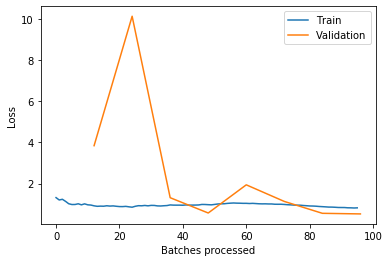

f18_224_lr_0.03_cyc_8_i5_m


Better model found at epoch 0 with accuracy value: 0.5170940160751343.
Better model found at epoch 1 with accuracy value: 0.632478654384613.
Better model found at epoch 2 with accuracy value: 0.7307692170143127.
Better model found at epoch 5 with accuracy value: 0.8504273295402527.


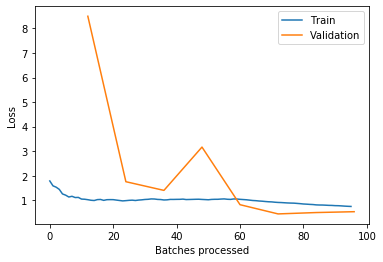

f18_224_lr_0.03_cyc_8_i6_m


Better model found at epoch 0 with accuracy value: 0.5427350401878357.
Better model found at epoch 1 with accuracy value: 0.6666666865348816.
Better model found at epoch 2 with accuracy value: 0.6752136945724487.
Better model found at epoch 3 with accuracy value: 0.7051281929016113.
Better model found at epoch 4 with accuracy value: 0.7735042572021484.
Better model found at epoch 5 with accuracy value: 0.867521345615387.


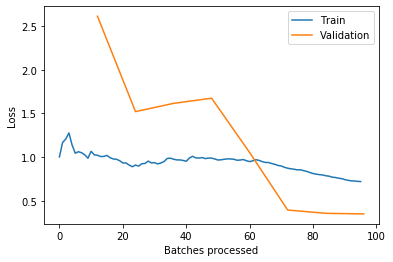

f18_224_lr_0.03_cyc_8_i7_m


Better model found at epoch 0 with accuracy value: 0.5170940160751343.
Better model found at epoch 2 with accuracy value: 0.5213675498962402.
Better model found at epoch 3 with accuracy value: 0.7008547186851501.
Better model found at epoch 4 with accuracy value: 0.7264957427978516.
Better model found at epoch 5 with accuracy value: 0.807692289352417.
Better model found at epoch 6 with accuracy value: 0.8589743375778198.


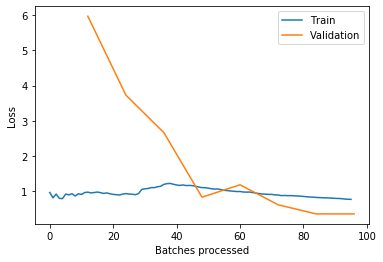

f18_224_lr_0.03_cyc_8_i8_m


Better model found at epoch 0 with accuracy value: 0.6111111044883728.
Better model found at epoch 3 with accuracy value: 0.7820512652397156.
Better model found at epoch 4 with accuracy value: 0.8247863054275513.
Better model found at epoch 5 with accuracy value: 0.8547008633613586.


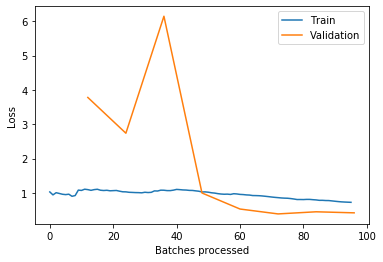

f18_224_lr_0.03_cyc_8_i9_m


Better model found at epoch 0 with accuracy value: 0.5726495981216431.
Better model found at epoch 2 with accuracy value: 0.7008547186851501.
Better model found at epoch 4 with accuracy value: 0.8247863054275513.
Better model found at epoch 6 with accuracy value: 0.867521345615387.


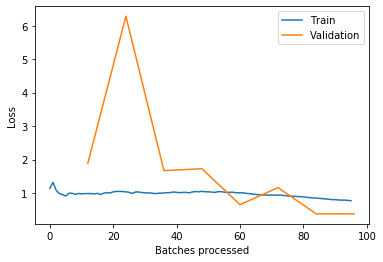

saved stats to: stats/f18_224_stats.p


In [48]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [49]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.150   Loss -- best: 0.209  med: 0.515

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.094   accuracy: 0.906   loss:0.2941
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167


f18_224_lr_0.003_cyc_4_i0_ls


Better model found at epoch 0 with accuracy value: 0.747863233089447.
Better model found at epoch 2 with accuracy value: 0.8290598392486572.
Better model found at epoch 3 with accuracy value: 0.8418803215026855.


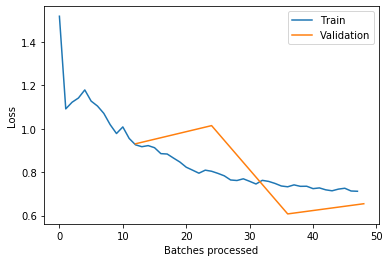

f18_224_lr_0.001_cyc_4_i0_ls


Better model found at epoch 0 with accuracy value: 0.7051281929016113.


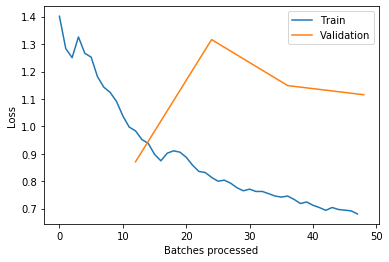

f18_224_lr_0.003_cyc_4_i1_ls


Better model found at epoch 0 with accuracy value: 0.807692289352417.
Better model found at epoch 3 with accuracy value: 0.8205128312110901.


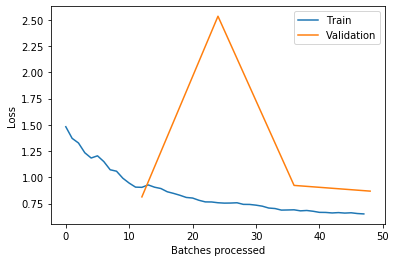

f18_224_lr_0.001_cyc_4_i1_ls


Better model found at epoch 0 with accuracy value: 0.7435897588729858.


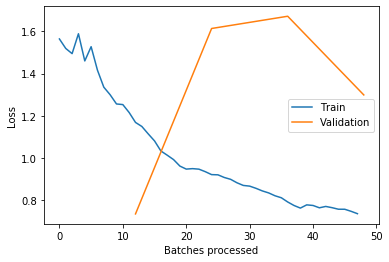

f18_224_lr_0.003_cyc_4_i2_ls


Better model found at epoch 0 with accuracy value: 0.7905982732772827.


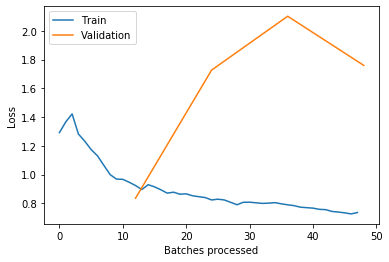

f18_224_lr_0.001_cyc_4_i2_ls


Better model found at epoch 0 with accuracy value: 0.7735042572021484.


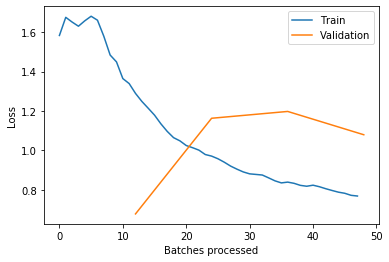

f18_224_lr_0.003_cyc_4_i3_ls


Better model found at epoch 0 with accuracy value: 0.692307710647583.


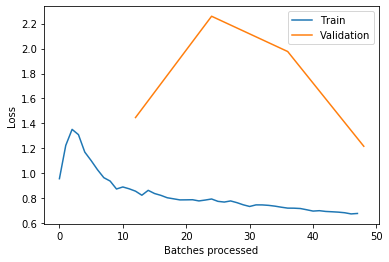

f18_224_lr_0.001_cyc_4_i3_ls


Better model found at epoch 0 with accuracy value: 0.6367521286010742.
Better model found at epoch 3 with accuracy value: 0.7307692170143127.


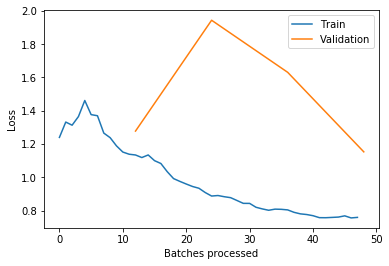

f18_224_lr_0.003_cyc_4_i4_ls


Better model found at epoch 0 with accuracy value: 0.7649572491645813.
Better model found at epoch 3 with accuracy value: 0.811965823173523.


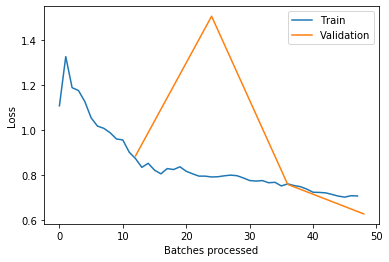

f18_224_lr_0.001_cyc_4_i4_ls


Better model found at epoch 0 with accuracy value: 0.6282051205635071.
Better model found at epoch 1 with accuracy value: 0.6367521286010742.
Better model found at epoch 2 with accuracy value: 0.6666666865348816.
Better model found at epoch 3 with accuracy value: 0.7136752009391785.


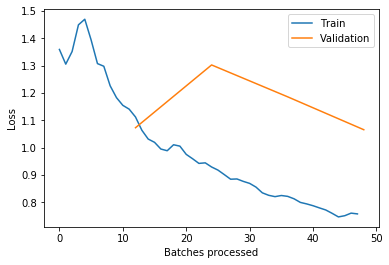

f18_224_lr_0.003_cyc_4_i5_ls


Better model found at epoch 0 with accuracy value: 0.7991452813148499.
Better model found at epoch 2 with accuracy value: 0.811965823173523.
Better model found at epoch 3 with accuracy value: 0.8162392973899841.


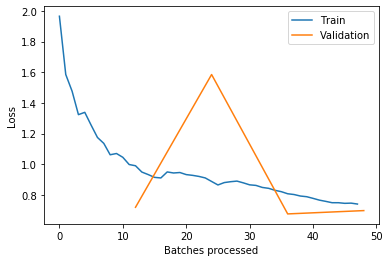

f18_224_lr_0.001_cyc_4_i5_ls


Better model found at epoch 0 with accuracy value: 0.6196581125259399.


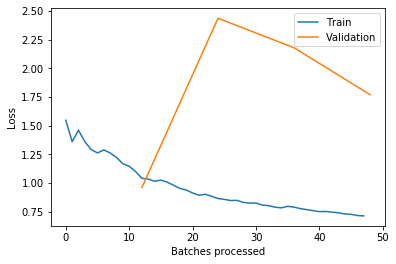

f18_224_lr_0.003_cyc_4_i6_ls


Better model found at epoch 0 with accuracy value: 0.8205128312110901.


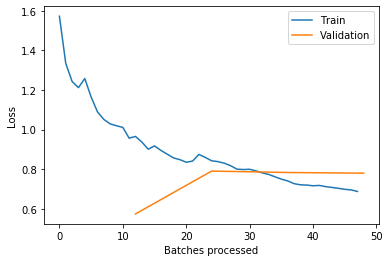

f18_224_lr_0.001_cyc_4_i6_ls


Better model found at epoch 0 with accuracy value: 0.7948718070983887.


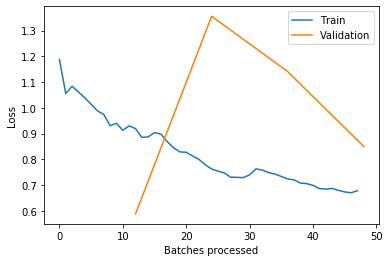

f18_224_lr_0.003_cyc_4_i7_ls


Better model found at epoch 0 with accuracy value: 0.7008547186851501.


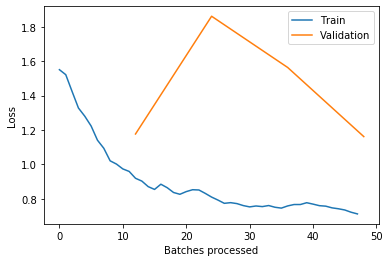

f18_224_lr_0.001_cyc_4_i7_ls


Better model found at epoch 0 with accuracy value: 0.6666666865348816.


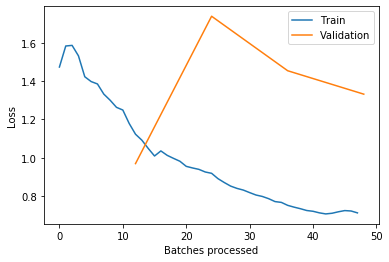

f18_224_lr_0.003_cyc_4_i8_ls


Better model found at epoch 0 with accuracy value: 0.7307692170143127.
Better model found at epoch 3 with accuracy value: 0.807692289352417.


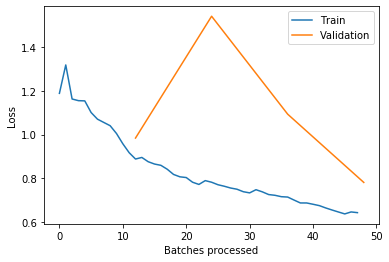

f18_224_lr_0.001_cyc_4_i8_ls


Better model found at epoch 0 with accuracy value: 0.7863247990608215.
Better model found at epoch 3 with accuracy value: 0.8205128312110901.


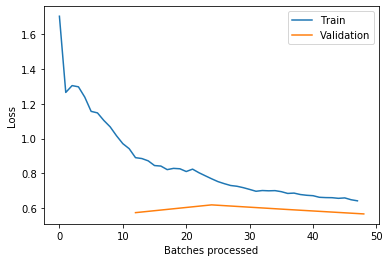

f18_224_lr_0.003_cyc_4_i9_ls


Better model found at epoch 0 with accuracy value: 0.6965811848640442.
Better model found at epoch 1 with accuracy value: 0.7393162250518799.
Better model found at epoch 2 with accuracy value: 0.8162392973899841.
Better model found at epoch 3 with accuracy value: 0.8290598392486572.


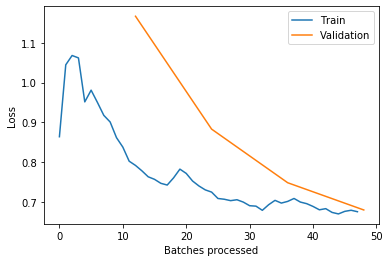

f18_224_lr_0.001_cyc_4_i9_ls


Better model found at epoch 0 with accuracy value: 0.7393162250518799.


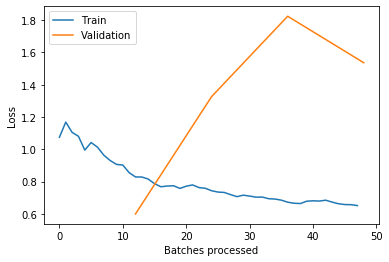

saved stats to: stats/f18_224_stats.p


In [50]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[3e-3, 1e-3]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

f18_224_lr_0.003_cyc_8_i0_ls


Better model found at epoch 0 with accuracy value: 0.7692307829856873.
Better model found at epoch 4 with accuracy value: 0.8290598392486572.
Better model found at epoch 5 with accuracy value: 0.8547008633613586.


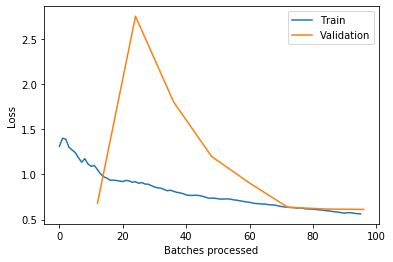

f18_224_lr_0.001_cyc_8_i0_ls


Better model found at epoch 0 with accuracy value: 0.7094017267227173.
Better model found at epoch 4 with accuracy value: 0.747863233089447.
Better model found at epoch 5 with accuracy value: 0.7905982732772827.
Better model found at epoch 6 with accuracy value: 0.8034188151359558.
Better model found at epoch 7 with accuracy value: 0.8205128312110901.


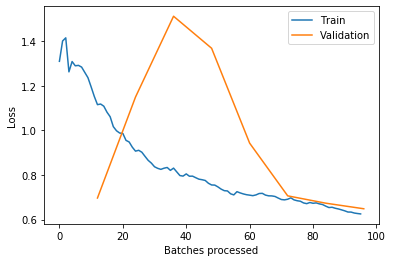

f18_224_lr_0.003_cyc_8_i1_ls


Better model found at epoch 0 with accuracy value: 0.7264957427978516.
Better model found at epoch 1 with accuracy value: 0.7905982732772827.
Better model found at epoch 4 with accuracy value: 0.8247863054275513.


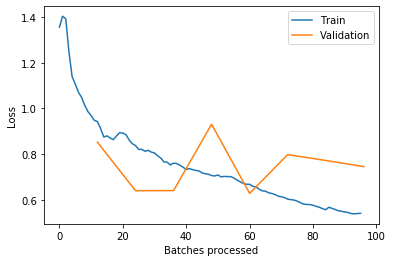

f18_224_lr_0.001_cyc_8_i1_ls


Better model found at epoch 0 with accuracy value: 0.7222222089767456.
Better model found at epoch 1 with accuracy value: 0.807692289352417.
Better model found at epoch 4 with accuracy value: 0.8461538553237915.
Better model found at epoch 5 with accuracy value: 0.867521345615387.
Better model found at epoch 6 with accuracy value: 0.8803418874740601.
Better model found at epoch 7 with accuracy value: 0.8846153616905212.


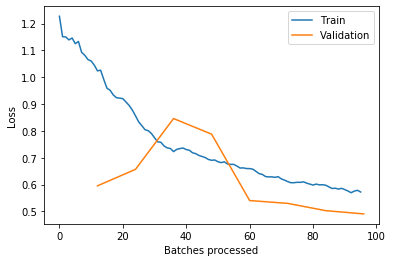

f18_224_lr_0.003_cyc_8_i2_ls


Better model found at epoch 0 with accuracy value: 0.7264957427978516.
Better model found at epoch 4 with accuracy value: 0.8205128312110901.
Better model found at epoch 5 with accuracy value: 0.8376068472862244.


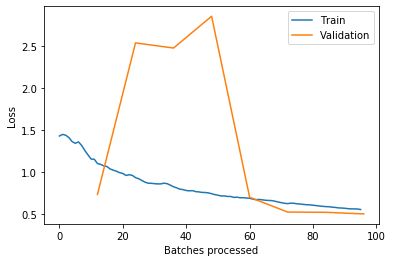

f18_224_lr_0.001_cyc_8_i2_ls


Better model found at epoch 0 with accuracy value: 0.752136766910553.
Better model found at epoch 1 with accuracy value: 0.7649572491645813.
Better model found at epoch 4 with accuracy value: 0.7692307829856873.
Better model found at epoch 5 with accuracy value: 0.811965823173523.
Better model found at epoch 6 with accuracy value: 0.8376068472862244.
Better model found at epoch 7 with accuracy value: 0.8418803215026855.


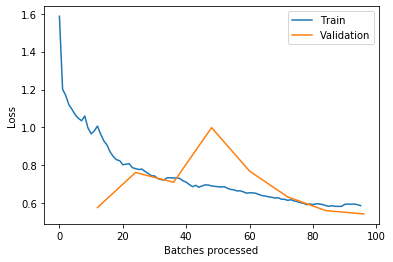

f18_224_lr_0.003_cyc_8_i3_ls


Better model found at epoch 0 with accuracy value: 0.7222222089767456.
Better model found at epoch 5 with accuracy value: 0.8247863054275513.
Better model found at epoch 6 with accuracy value: 0.8632478713989258.
Better model found at epoch 7 with accuracy value: 0.8760683536529541.


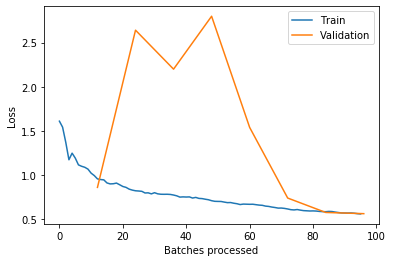

f18_224_lr_0.001_cyc_8_i3_ls


Better model found at epoch 0 with accuracy value: 0.7264957427978516.
Better model found at epoch 5 with accuracy value: 0.7820512652397156.
Better model found at epoch 6 with accuracy value: 0.8290598392486572.
Better model found at epoch 7 with accuracy value: 0.8376068472862244.


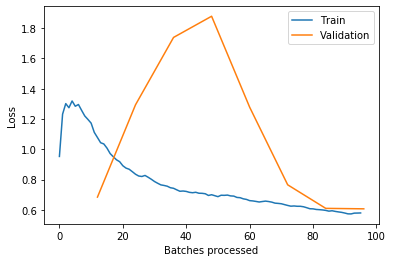

f18_224_lr_0.003_cyc_8_i4_ls


Better model found at epoch 0 with accuracy value: 0.811965823173523.
Better model found at epoch 3 with accuracy value: 0.8247863054275513.
Better model found at epoch 5 with accuracy value: 0.8333333134651184.
Better model found at epoch 6 with accuracy value: 0.8589743375778198.
Better model found at epoch 7 with accuracy value: 0.8632478713989258.


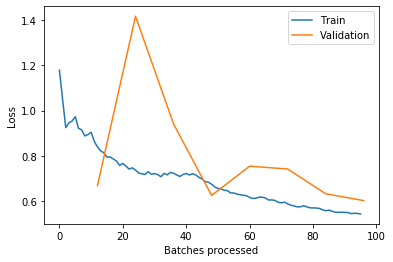

f18_224_lr_0.001_cyc_8_i4_ls


Better model found at epoch 0 with accuracy value: 0.8205128312110901.
Better model found at epoch 5 with accuracy value: 0.8547008633613586.


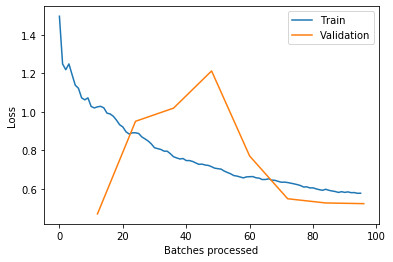

f18_224_lr_0.003_cyc_8_i5_ls


Better model found at epoch 0 with accuracy value: 0.8376068472862244.
Better model found at epoch 4 with accuracy value: 0.8504273295402527.


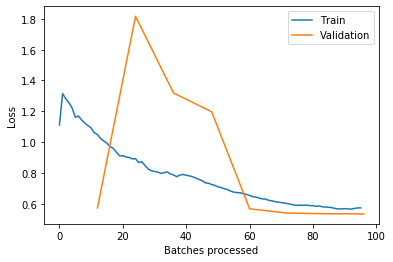

f18_224_lr_0.001_cyc_8_i5_ls


Better model found at epoch 0 with accuracy value: 0.7051281929016113.
Better model found at epoch 4 with accuracy value: 0.8376068472862244.
Better model found at epoch 5 with accuracy value: 0.8632478713989258.


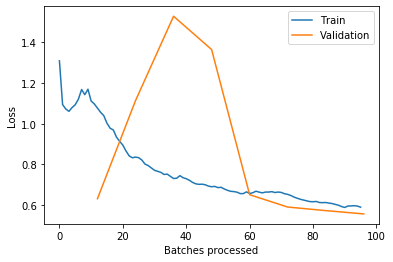

f18_224_lr_0.003_cyc_8_i6_ls


Better model found at epoch 0 with accuracy value: 0.8034188151359558.
Better model found at epoch 6 with accuracy value: 0.807692289352417.


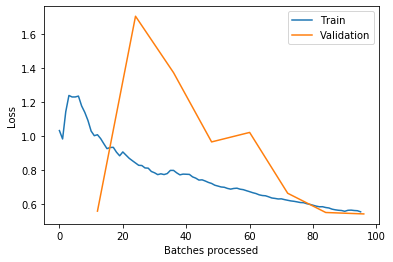

f18_224_lr_0.001_cyc_8_i6_ls


Better model found at epoch 0 with accuracy value: 0.7564102411270142.
Better model found at epoch 3 with accuracy value: 0.7820512652397156.
Better model found at epoch 4 with accuracy value: 0.8589743375778198.
Better model found at epoch 5 with accuracy value: 0.8760683536529541.


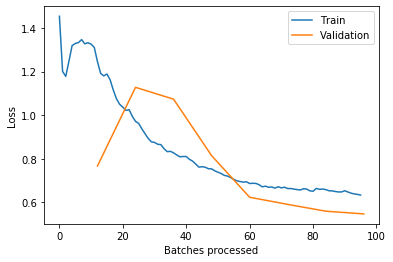

f18_224_lr_0.003_cyc_8_i7_ls


Better model found at epoch 0 with accuracy value: 0.807692289352417.
Better model found at epoch 2 with accuracy value: 0.8418803215026855.
Better model found at epoch 4 with accuracy value: 0.8547008633613586.
Better model found at epoch 5 with accuracy value: 0.8589743375778198.
Better model found at epoch 7 with accuracy value: 0.867521345615387.


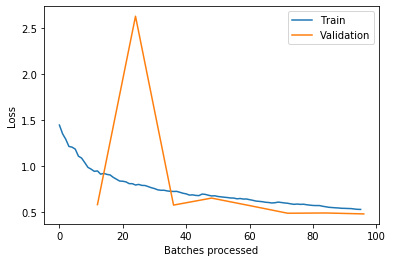

f18_224_lr_0.001_cyc_8_i7_ls


Better model found at epoch 0 with accuracy value: 0.7094017267227173.
Better model found at epoch 2 with accuracy value: 0.7735042572021484.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.
Better model found at epoch 4 with accuracy value: 0.8376068472862244.
Better model found at epoch 6 with accuracy value: 0.867521345615387.


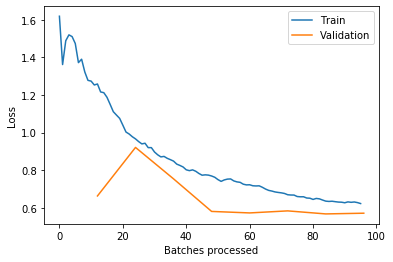

f18_224_lr_0.003_cyc_8_i8_ls


Better model found at epoch 0 with accuracy value: 0.7094017267227173.
Better model found at epoch 2 with accuracy value: 0.8205128312110901.
Better model found at epoch 5 with accuracy value: 0.8376068472862244.


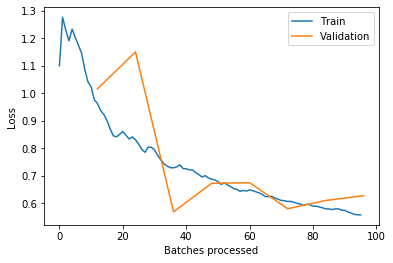

f18_224_lr_0.001_cyc_8_i8_ls


Better model found at epoch 0 with accuracy value: 0.7051281929016113.
Better model found at epoch 4 with accuracy value: 0.7264957427978516.
Better model found at epoch 5 with accuracy value: 0.8290598392486572.
Better model found at epoch 6 with accuracy value: 0.8376068472862244.


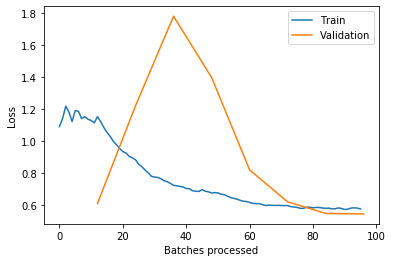

f18_224_lr_0.003_cyc_8_i9_ls


Better model found at epoch 0 with accuracy value: 0.7008547186851501.
Better model found at epoch 1 with accuracy value: 0.747863233089447.
Better model found at epoch 3 with accuracy value: 0.8418803215026855.
Better model found at epoch 7 with accuracy value: 0.8461538553237915.


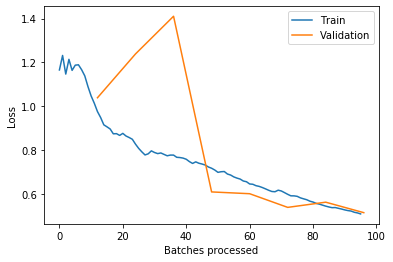

f18_224_lr_0.001_cyc_8_i9_ls


Better model found at epoch 0 with accuracy value: 0.747863233089447.
Better model found at epoch 3 with accuracy value: 0.7649572491645813.
Better model found at epoch 4 with accuracy value: 0.8205128312110901.
Better model found at epoch 5 with accuracy value: 0.8547008633613586.
Better model found at epoch 7 with accuracy value: 0.8589743375778198.


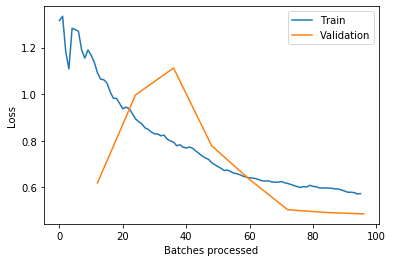

saved stats to: stats/f18_224_stats.p


In [51]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[3e-3,1e-3]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

f18_224_lr_0.02_cyc_8_i0_ls


Better model found at epoch 0 with accuracy value: 0.8290598392486572.


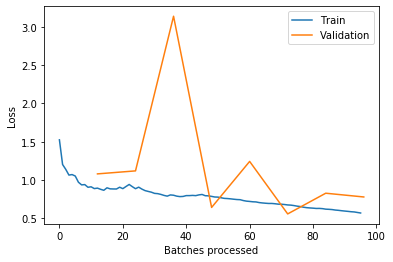

f18_224_lr_0.01_cyc_8_i0_ls


Better model found at epoch 0 with accuracy value: 0.5341880321502686.
Better model found at epoch 1 with accuracy value: 0.7222222089767456.
Better model found at epoch 4 with accuracy value: 0.7820512652397156.
Better model found at epoch 5 with accuracy value: 0.8290598392486572.
Better model found at epoch 6 with accuracy value: 0.8504273295402527.


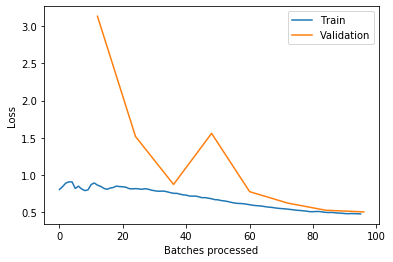

f18_224_lr_0.02_cyc_8_i1_ls


Better model found at epoch 0 with accuracy value: 0.5769230723381042.
Better model found at epoch 1 with accuracy value: 0.6837607026100159.
Better model found at epoch 2 with accuracy value: 0.8547008633613586.
Better model found at epoch 6 with accuracy value: 0.8974359035491943.


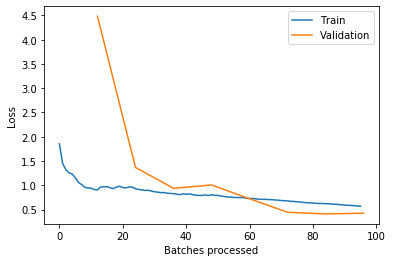

f18_224_lr_0.01_cyc_8_i1_ls


Better model found at epoch 0 with accuracy value: 0.7735042572021484.
Better model found at epoch 4 with accuracy value: 0.8589743375778198.
Better model found at epoch 5 with accuracy value: 0.867521345615387.


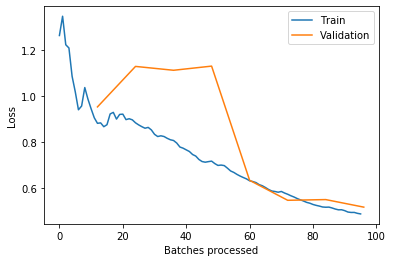

f18_224_lr_0.02_cyc_8_i2_ls


Better model found at epoch 0 with accuracy value: 0.7649572491645813.
Better model found at epoch 3 with accuracy value: 0.867521345615387.


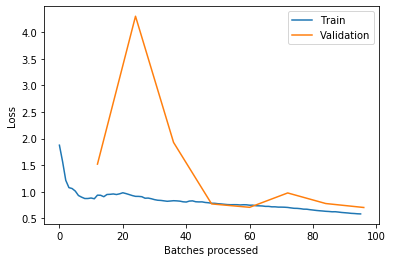

f18_224_lr_0.01_cyc_8_i2_ls


Better model found at epoch 0 with accuracy value: 0.807692289352417.
Better model found at epoch 1 with accuracy value: 0.811965823173523.
Better model found at epoch 3 with accuracy value: 0.8376068472862244.
Better model found at epoch 4 with accuracy value: 0.8589743375778198.


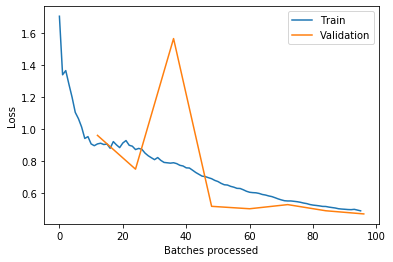

f18_224_lr_0.02_cyc_8_i3_ls


Better model found at epoch 0 with accuracy value: 0.5341880321502686.
Better model found at epoch 1 with accuracy value: 0.7051281929016113.
Better model found at epoch 4 with accuracy value: 0.8247863054275513.


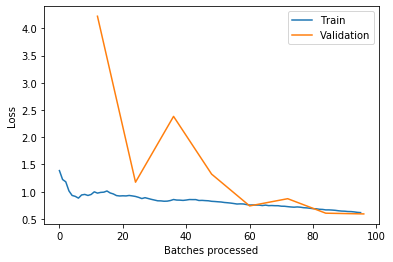

f18_224_lr_0.01_cyc_8_i3_ls


Better model found at epoch 0 with accuracy value: 0.5512820482254028.
Better model found at epoch 1 with accuracy value: 0.7350427508354187.
Better model found at epoch 4 with accuracy value: 0.807692289352417.
Better model found at epoch 7 with accuracy value: 0.8461538553237915.


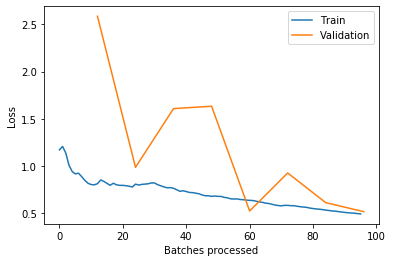

f18_224_lr_0.02_cyc_8_i4_ls


Better model found at epoch 0 with accuracy value: 0.5341880321502686.
Better model found at epoch 2 with accuracy value: 0.6965811848640442.
Better model found at epoch 3 with accuracy value: 0.7735042572021484.
Better model found at epoch 6 with accuracy value: 0.807692289352417.


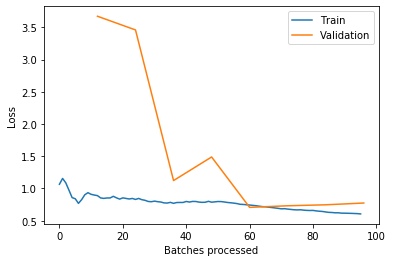

f18_224_lr_0.01_cyc_8_i4_ls


Better model found at epoch 0 with accuracy value: 0.5512820482254028.
Better model found at epoch 2 with accuracy value: 0.6239316463470459.
Better model found at epoch 3 with accuracy value: 0.8504273295402527.
Better model found at epoch 4 with accuracy value: 0.8931623697280884.


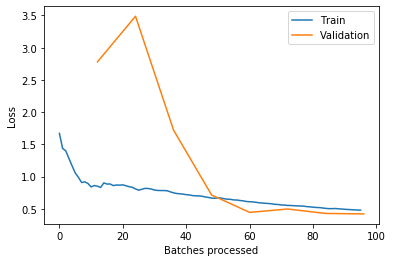

f18_224_lr_0.02_cyc_8_i5_ls


Better model found at epoch 0 with accuracy value: 0.6239316463470459.
Better model found at epoch 3 with accuracy value: 0.6752136945724487.
Better model found at epoch 4 with accuracy value: 0.7863247990608215.
Better model found at epoch 5 with accuracy value: 0.7905982732772827.
Better model found at epoch 7 with accuracy value: 0.7948718070983887.


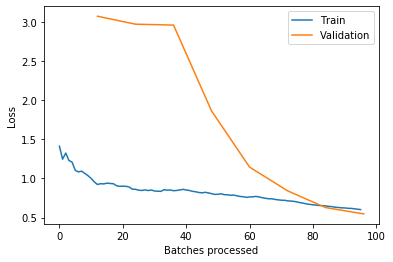

f18_224_lr_0.01_cyc_8_i5_ls


Better model found at epoch 0 with accuracy value: 0.7649572491645813.
Better model found at epoch 1 with accuracy value: 0.7692307829856873.
Better model found at epoch 2 with accuracy value: 0.7863247990608215.
Better model found at epoch 4 with accuracy value: 0.8461538553237915.
Better model found at epoch 5 with accuracy value: 0.8547008633613586.
Better model found at epoch 6 with accuracy value: 0.8760683536529541.


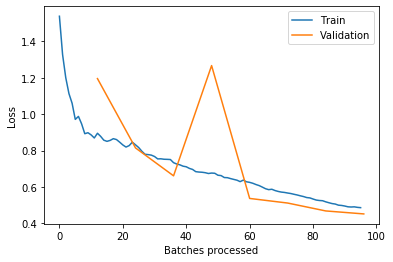

f18_224_lr_0.02_cyc_8_i6_ls


Better model found at epoch 0 with accuracy value: 0.632478654384613.
Better model found at epoch 1 with accuracy value: 0.8247863054275513.
Better model found at epoch 5 with accuracy value: 0.8290598392486572.
Better model found at epoch 6 with accuracy value: 0.8461538553237915.
Better model found at epoch 7 with accuracy value: 0.8589743375778198.


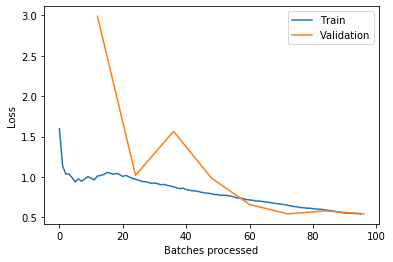

f18_224_lr_0.01_cyc_8_i6_ls


Better model found at epoch 0 with accuracy value: 0.5982906222343445.
Better model found at epoch 1 with accuracy value: 0.692307710647583.
Better model found at epoch 2 with accuracy value: 0.7008547186851501.
Better model found at epoch 3 with accuracy value: 0.7222222089767456.
Better model found at epoch 4 with accuracy value: 0.7692307829856873.
Better model found at epoch 5 with accuracy value: 0.8717948794364929.


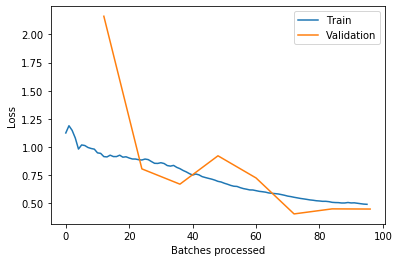

f18_224_lr_0.02_cyc_8_i7_ls


Better model found at epoch 0 with accuracy value: 0.6196581125259399.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.
Better model found at epoch 5 with accuracy value: 0.8760683536529541.


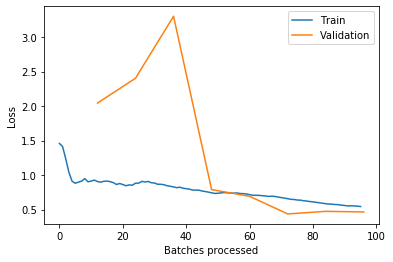

f18_224_lr_0.01_cyc_8_i7_ls


Better model found at epoch 0 with accuracy value: 0.688034176826477.
Better model found at epoch 2 with accuracy value: 0.7051281929016113.
Better model found at epoch 3 with accuracy value: 0.752136766910553.
Better model found at epoch 4 with accuracy value: 0.7735042572021484.
Better model found at epoch 5 with accuracy value: 0.8290598392486572.
Better model found at epoch 6 with accuracy value: 0.8803418874740601.


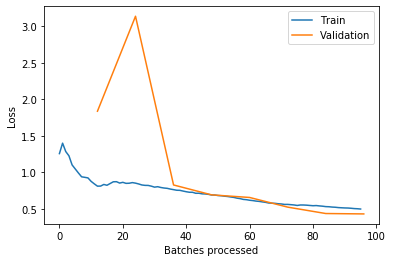

f18_224_lr_0.02_cyc_8_i8_ls


Better model found at epoch 0 with accuracy value: 0.5555555820465088.
Better model found at epoch 1 with accuracy value: 0.6068376302719116.
Better model found at epoch 3 with accuracy value: 0.7820512652397156.
Better model found at epoch 4 with accuracy value: 0.8504273295402527.


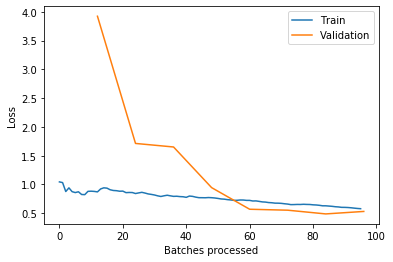

f18_224_lr_0.01_cyc_8_i8_ls


Better model found at epoch 0 with accuracy value: 0.867521345615387.


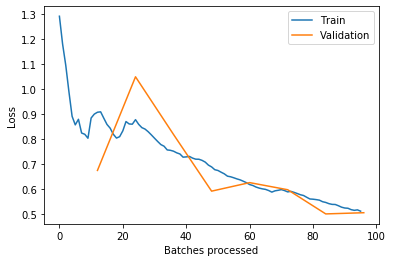

f18_224_lr_0.02_cyc_8_i9_ls


Better model found at epoch 0 with accuracy value: 0.8034188151359558.
Better model found at epoch 4 with accuracy value: 0.8461538553237915.


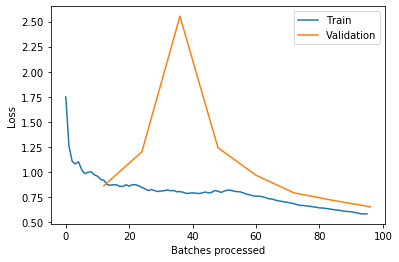

f18_224_lr_0.01_cyc_8_i9_ls


Better model found at epoch 0 with accuracy value: 0.747863233089447.
Better model found at epoch 2 with accuracy value: 0.7820512652397156.
Better model found at epoch 3 with accuracy value: 0.8461538553237915.
Better model found at epoch 4 with accuracy value: 0.867521345615387.
Better model found at epoch 5 with accuracy value: 0.8846153616905212.
Better model found at epoch 6 with accuracy value: 0.9017093777656555.


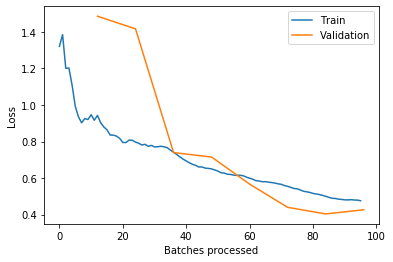

saved stats to: stats/f18_224_stats.p


In [52]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[2e-2, 1e-2]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

In [53]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.154   Loss -- best: 0.209  med: 0.554

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.094   accuracy: 0.906   loss:0.2941
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167


In [54]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.154   Loss -- best: 0.209  med: 0.554

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.094   accuracy: 0.906   loss:0.2941
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167


## Summary of Results

In [55]:
for key in [None, 'lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12',  'cyc_16', 
            '_m', 'ls', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, show_details=False)

Overall         Error -- best: 0.064  med: 0.154   Loss -- best: 0.209  med: 0.554
lr_0.03         Error -- best: 0.081  med: 0.173   Loss -- best: 0.267  med: 0.676
lr_0.02         Error -- best: 0.094  med: 0.141   Loss -- best: 0.239  med: 0.534
lr_0.01         Error -- best: 0.064  med: 0.132   Loss -- best: 0.209  med: 0.486
lr_0.003        Error -- best: 0.124  med: 0.177   Loss -- best: 0.404  med: 0.632
lr_0.001        Error -- best: 0.094  med: 0.160   Loss -- best: 0.317  med: 0.567
lr_0.0003       Error -- best: 0.115  med: 0.137   Loss -- best: 0.423  med: 0.443
lr_0.0001       Error -- best: 0.120  med: 0.171   Loss -- best: 0.356  med: 0.434
cyc_4           Error -- best: 0.124  med: 0.188   Loss -- best: 0.317  med: 0.756
cyc_8           Error -- best: 0.081  med: 0.141   Loss -- best: 0.267  med: 0.515
cyc_12          Error -- best: 0.064  med: 0.094   Loss -- best: 0.209  med: 0.346
cyc_16          Error -- best: 0.094  med: 0.128   Loss -- best: 0.239  med: 0.432
_m  

In [56]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.154   Loss -- best: 0.209  med: 0.554

f18_224_lr_0.01_cyc_12_i4  error_rate: 0.064   accuracy: 0.936   loss:0.2399
f18_224_lr_0.01_cyc_12_i7  error_rate: 0.068   accuracy: 0.932   loss:0.2091
f18_224_lr_0.01_cyc_12_i0  error_rate: 0.077   accuracy: 0.923   loss:0.3624
f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.01_cyc_12_i5  error_rate: 0.081   accuracy: 0.919   loss:0.2268
f18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.094   accuracy: 0.906   loss:0.2941
f18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.094   accuracy: 0.906   loss:0.4685
f18_224_lr_0.01_cyc_8_i7  error_rate: 0.094   accuracy: 0.906   loss:0.3134
f18_224_lr_0.01_cyc_12_i3  error_rate: 0.094   accuracy: 0.906   loss:0.3295
f18_224_lr_0.01_cyc_12_i9  error_rate: 0.094   accuracy: 0.906   loss:0.3167


In [57]:
for key in ['lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12', 'cyc_16', 
            '_m', 'ls', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, limit=6)
    print('\n')

lr_0.03         Error -- best: 0.081  med: 0.173   Loss -- best: 0.267  med: 0.676

f18_224_lr_0.03_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2667
f18_224_lr_0.03_cyc_8_i0  error_rate: 0.115   accuracy: 0.885   loss:0.3651
f18_224_lr_0.03_cyc_8_i5  error_rate: 0.124   accuracy: 0.876   loss:0.3501
f18_224_lr_0.03_cyc_8_i9_m  error_rate: 0.132   accuracy: 0.868   loss:0.3791
f18_224_lr_0.03_cyc_8_i6_m  error_rate: 0.132   accuracy: 0.868   loss:0.3928
f18_224_lr_0.03_cyc_8_i8  error_rate: 0.137   accuracy: 0.863   loss:0.4658


lr_0.02         Error -- best: 0.094  med: 0.141   Loss -- best: 0.239  med: 0.534

f18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.094   accuracy: 0.906   loss:0.2941
f18_224_lr_0.02_cyc_16_i4_m  error_rate: 0.098   accuracy: 0.902   loss:0.2673
f18_224_lr_0.02_cyc_8_i1_ls  error_rate: 0.103   accuracy: 0.897   loss:0.4091
f18_224_lr_0.02_cyc_8_i3  error_rate: 0.107   accuracy: 0.893   loss:0.3425
f18_224_lr_0.02_cyc_8_i9  error_rate: 0.107   accuracy: 0.89

In [58]:
#assert False

## Inference

- try composite of 4 learners
- try test-time augmentation

In [59]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
name = top_results[0]
print(name)

f18_224_lr_0.01_cyc_12_i4



f18_224_lr_0.01_cyc_12_i4 Validation tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          93%         94%        93%        0.94
PNEUMONIA       94%         93%        94%        0.94


Overall Accuracy: 93.59%


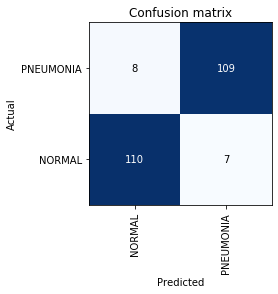

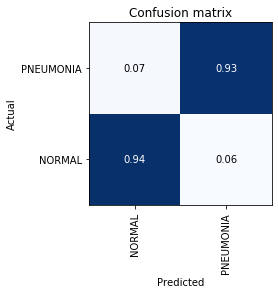

In [60]:
interp = get_interp(name)
print(f'\n{name} Validation tta=False')
analyze_interp(interp)


f18_224_lr_0.01_cyc_12_i4 Test tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          89%         86%        90%        0.88
PNEUMONIA       87%         90%        86%        0.88


Overall Accuracy: 88.03%


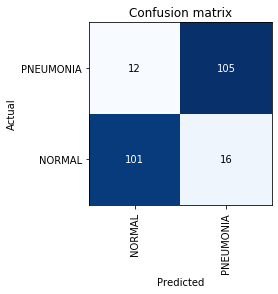

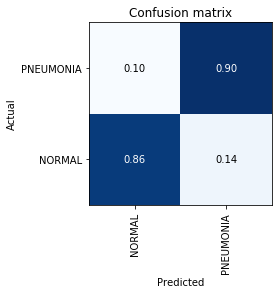

In [61]:
interp = get_interp_test(name)
print(f'\n{name} Test tta=False')
analyze_interp(interp)

#### Use TTA


f18_224_lr_0.01_cyc_12_i4 Validation tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          95%         86%        96%        0.91
PNEUMONIA       88%         96%        86%        0.91


Overall Accuracy: 91.03%


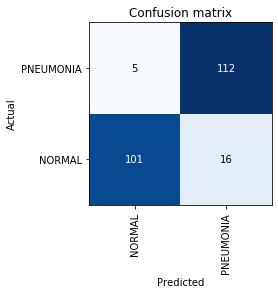

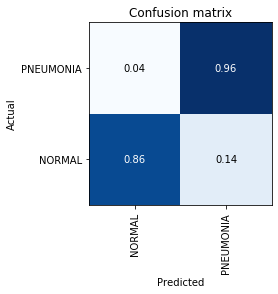

In [62]:
interp = get_interp(name, use_tta=True)
print(f'\n{name} Validation tta=True')
analyze_interp(interp)


f18_224_lr_0.01_cyc_12_i4 Test tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          92%         78%        93%        0.84
PNEUMONIA       81%         93%        78%        0.87


Overall Accuracy: 85.47%


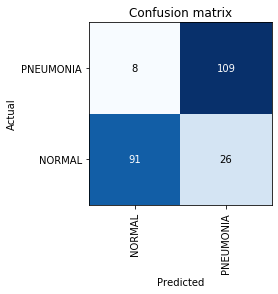

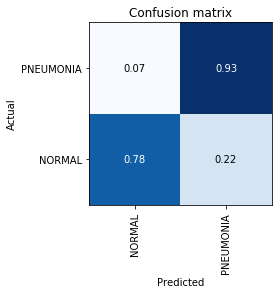

In [63]:
interp = get_interp_test(name, use_tta=True)
print(f'\n{name} Test tta=True')
analyze_interp(interp)

### Composite for Validation based on accuracy

In [64]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

accuracy -- mean: 0.932   median: 0.932   gmean: 0.932   hmean: 0.927


#### Show Individual - for Validation dataset

f18_224_lr_0.01_cyc_12_i4
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          93%         94%        93%        0.94
PNEUMONIA       94%         93%        94%        0.94


Overall Accuracy: 93.59%


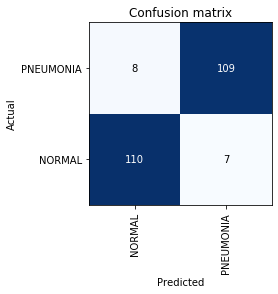

f18_224_lr_0.01_cyc_12_i7
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          95%         92%        95%        0.94
PNEUMONIA       92%         95%        92%        0.94


Overall Accuracy: 93.59%


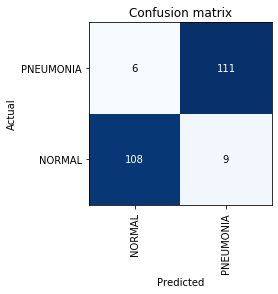

f18_224_lr_0.01_cyc_12_i0
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          95%         89%        95%        0.92
PNEUMONIA       90%         95%        89%        0.92


Overall Accuracy: 91.88%


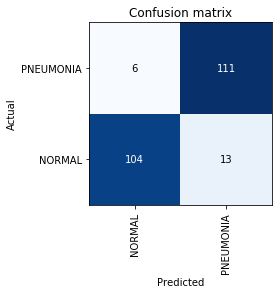

f18_224_lr_0.03_cyc_8
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          90%         94%        90%        0.92
PNEUMONIA       94%         90%        94%        0.92


Overall Accuracy: 91.88%


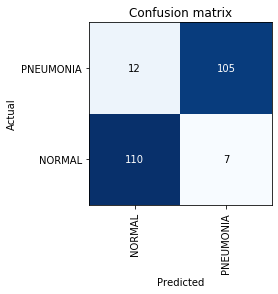

In [65]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

### Composite for Validation based on loss

In [66]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

accuracy -- mean: 0.940   median: 0.949   gmean: 0.940   hmean: 0.936


### Composite for Test based on accuracy

In [67]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.910   median: 0.919   gmean: 0.906   hmean: 0.902


#### Individual results for top 4

f18_224_lr_0.01_cyc_12_i4
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          89%         86%        90%        0.88
PNEUMONIA       87%         90%        86%        0.88


Overall Accuracy: 88.03%


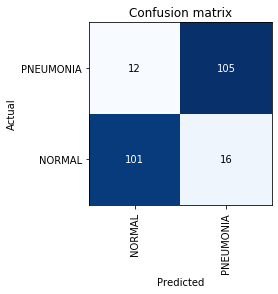

f18_224_lr_0.01_cyc_12_i7
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          93%         86%        93%        0.89
PNEUMONIA       87%         93%        86%        0.90


Overall Accuracy: 89.74%


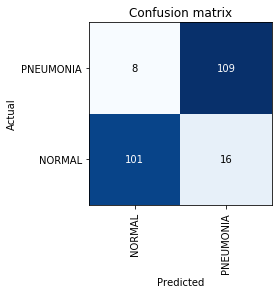

f18_224_lr_0.01_cyc_12_i0
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          95%         80%        96%        0.87
PNEUMONIA       83%         96%        80%        0.89


Overall Accuracy: 88.03%


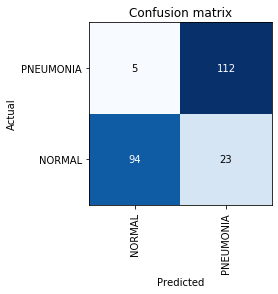

f18_224_lr_0.03_cyc_8
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          90%         87%        91%        0.89
PNEUMONIA       88%         91%        87%        0.89


Overall Accuracy: 88.89%


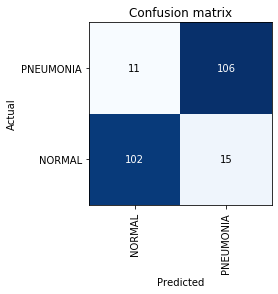

In [68]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

#### Try again using TTA

In [69]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name, use_tta=True)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.868   median: 0.863   gmean: 0.872   hmean: 0.872


### Composite for Test based on loss

In [70]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.893   median: 0.897   gmean: 0.902   hmean: 0.902


#### Try again using TTA

In [71]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name, use_tta=True)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.889   median: 0.893   gmean: 0.889   hmean: 0.885


In [72]:
assert False

AssertionError: 

## Experiment with fine tuning classifier

In [ ]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(2e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-4))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-5))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=2)
stats, new_name

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=8)
stats, new_name

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=8)
    foo.append([1, stats])
foo

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=16)
    foo.append([1, stats])
    print('\n')
foo